In [189]:
import sys
sys.path.insert(0, '../Triangulation/')
sys.path.insert(0, '../network_datasets')
sys.path.insert(0, '../point_coordinates_regression/')

In [194]:
from Triangulation import *
from Neural_network import *
from functools import reduce
import Triangulation_with_points



import torch
import torch.optim as optim

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
from point_coordinates_regression import *

In [195]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def triangulate_old_vers(polygon,ordered_quality_matrix,recursive=True):
    set_edges=set(tuple(i) for i in get_contour_edges(polygon))
    interior_edges=set()
    set_elements=set()
    set_locked_vertices=set()
    set_forbidden_intersections=set()
    
    print("initial set edges:", set_edges)
    


    for edge in ordered_quality_matrix.keys():
        
        found_in_interior_set,found_in_set,index=check_edge_validity(edge,polygon,set_edges,interior_edges)
        
        for qualities_with_edges in ordered_quality_matrix[edge][0]:
            
            element_created=False
           
            target_vtx=qualities_with_edges[1]
            
            if target_vtx==edge[0] or target_vtx==edge[1]:
                continue
           
            print("Edge:",edge,"targeting:",target_vtx)
        
            if found_in_interior_set:
                element=(edge[0],edge[1],index)  
                set_elements.add(element)
                print("Element inserted:",element)
                continue
        
            if found_in_set and not found_in_interior_set:    
                if(index != target_vtx):
                    print('found',(edge[0],index),(edge[1],index),"Canceling creation")
                    continue        
        
        
        
            # Passed edges checking 
            # Proceed to check vertices
            temp_element=(edge[0],edge[1],target_vtx)
            print(temp_element)
            existing_element=False
            for element in set_elements:
                if set(temp_element)== set(element):
                    print("Element {} already in set".format(element))
                    existing_element=True
                    break
            if existing_element:
                break
            
            
            
            if target_vtx in set_locked_vertices:
                print(" Target vertex {} is locked".format(target_vtx))
                continue
            set_elements.add(temp_element)

            
    
            # Check if a locked vertex was created after the creation of the element
            # If so, add it to the list
            #Tracer()()
            Found_locked_vertex=False
            for vertex in temp_element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                    print("Vertex locked:",vertex)
                    Found_locked_vertex=True
                    set_locked_vertices.add(vertex)
            set_elements.remove(temp_element)
            
        
        
            # Locking the vertices and checking if the connection is with a locked vertex has been checked/
            # Proceeding to check if both internal edges intersect with other internal edges
            internal_edge1=(edge[0],target_vtx)
            internal_edge2=(edge[1],target_vtx)
            set_a,set_b=get_intermediate_indices(target_vtx,polygon,edge[0],edge[1])
        
            internal_condition1= internal_edge1 in set_forbidden_intersections or tuple(reversed(internal_edge1)) in set_forbidden_intersections
                                                                        
            internal_condition2=internal_edge2 in set_forbidden_intersections or tuple(reversed(internal_edge2)) in set_forbidden_intersections
                                                                            
    
                                                                                   
            internal_intersection=False
            if internal_condition1 or  internal_condition2:
                print("edges :",internal_edge1, "and",internal_edge2,"intersecting")
                print("Abandoning creation of element",temp_element)
                internal_intersection=True
        
     
            if internal_intersection:
                for vtx in temp_element:
                    if Found_locked_vertex and vtx in set_locked_vertices:
                        print("Unlocking vertex",vtx)
                        set_locked_vertices.remove(vtx)                    
                continue
        
        
        
            # Create the element
            element=temp_element
        
            triangle=polygon[np.asarray(element)]
            
            if compute_mean_quality_triangle(triangle,polygon)==0:
                continue
            
            # Add to set of edges all the forbidden intersections after the creation of the element
            
            for i in set_a:
                for j in set_b:
                    set_forbidden_intersections.add((i,j))
            #print("set of forbidden inter section edges updated:",set_forbidden_intersections)
    
                
        
        
        # New edges after creation of the element
   
            new_edge1=(edge[0],target_vtx)
            new_edge2=(edge[1],target_vtx)
        
            if new_edge1 not in set_edges and tuple(reversed(new_edge1)) not in set_edges:
                set_edges.add(new_edge1)
                interior_edges.add(new_edge1)
                print("edges inserted:",new_edge1)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            if new_edge2 not in set_edges and tuple(reversed(new_edge2)) not in set_edges:    
                set_edges.add(new_edge2)
                interior_edges.add(new_edge2)
                print("edges inserted:",new_edge2)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            
        
    
    
            # Checking list of elements to see whether the were created or were already there
            
            
            set_elements.add(element)
            element_created=True
                
            if element_created:
                print("element inserted:",element)

                break
            else:
                continue
        
        
            
    
    
    triangulated={'segment_markers': np.ones([polygon.shape[0]]), 'segments':np.array(get_contour_edges(polygon)), 'triangles': np.array(list( list(i) for i in set_elements)),
                  'vertex_markers': np.ones([polygon.shape[0]]), 'vertices': polygon}
    plot.plot(plt.axes(), **triangulated)
    print("Final edges:",set_edges)
    print("Elements created:",set_elements)
    print("Set of locked vertices:", set_locked_vertices)
    
    
    # find open vertices
    for element in set_elements:
        for vertex in  element:
                    _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                    if isclosed and vertex not in set_locked_vertices:
                        print("Vertex locked:",vertex)
                        Found_locked_vertex=True
                        set_locked_vertices.add(vertex)
    set_open_vertices=set(range(len(polygon)))-set_locked_vertices
    print("Set of open vertices:", set_open_vertices)
    set_edges.clear(),set_locked_vertices.clear(),set_forbidden_intersections.clear
    if recursive:
        sub_polygon_list=check_for_sub_polygon(set_open_vertices,interior_edges,set_elements,polygon)
        for sub_polygon_indices in sub_polygon_list:
            if len(sub_polygon_indices)>=3:
                print("remeshing subpolygon",sub_polygon_indices)
                polygon_copy=polygon
                sub_polygon=np.array(polygon_copy[sub_polygon_indices])
                if not is_counterclockwise(sub_polygon):
                    sub_polygon=np.array(polygon_copy[sub_polygon_indices[::-1]])

                sub_quality,_=quality_matrix(sub_polygon,compute_minimum=True,normalize=False)
                sub_order_matrix=order_quality_matrix(sub_quality,sub_polygon,check_for_equal=True)
                print(sub_quality,sub_order_matrix)
                triangulate(sub_polygon,sub_order_matrix,recursive=True)



In [196]:
def batch_size_factor(n,minimum,maximum):    
    factor_set=set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    for factor in factor_set:
        if factor>minimum and factor<maximum:
            batch_size_factor=factor
    return batch_size_factor
    

In [104]:
# load the datasets

Polygons,quality_matrices=load_dataset('6_polygons.pkl'),load_dataset('6_polygons_qualities_mean.pkl')

In [105]:
# Testing data are usually 20 percent of the whole

nb_of_points=6
nb_of_contours=int(Polygons.shape[0])

nb_test_data=int(0.2*Polygons.shape[0])
nb_training_data=int(Polygons.shape[0])-nb_test_data


In [106]:
#reshaping the polygon data with respect to NN

Polygons_reshaped=[]



for i in range(nb_of_contours):
    Polygons_reshaped.append(Polygons[i].reshape(2*nb_of_points))

Polygons_reshaped=np.array(Polygons_reshaped) 


In [342]:
nb_of_edges=6
nb_of_points=4

In [343]:
filedirectory='..//polygon_datasets//'+str(int(nb_of_edges))+'_polygons_with_points'
del_points=load_dataset(str(nb_of_edges)+'_point_coordinates_del.pkl')
number_of_insertion_points=load_dataset(str(nb_of_edges)+'_nb_of_points_del.pkl')


set_points=get_set_nb_of_points(del_points)

for nb_of_inner_points in [4]:
    if nb_of_inner_points==0:
        continue

    print(nb_of_inner_points)
    polygons_filename=os.path.join(filedirectory, str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_polygons_with_points')
    qualities_filename=os.path.join(filedirectory,str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_polygons_qualities_min.pkl')

    with open (polygons_filename,'rb') as file:
        polygons_with_points=pickle.load(file)



    with open (qualities_filename,'rb') as file:
        quality_matrices=pickle.load(file)

4


In [344]:
if (nb_of_edges==8 and nb_of_inner_points==1) or (nb_of_edges==10 and nb_of_inner_points==1) or (nb_of_edges==12 and nb_of_inner_points==4):
        filename_polygons='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_polygons_with_points.pkl'
        filename_min_qualities='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_min_qualities.pkl'
     #   filename_polygons2='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_polygons_with_points_part_2.pkl'
      #  filename_min_qualities2='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_inner_points)+'_min_qualities_part_2.pkl'
        with open(filename_polygons,'rb') as f:
            additional_polygons_with_points=pickle.load(f)
        with open(filename_min_qualities,'rb') as f:
            additional_min_qualities=pickle.load(f)  
      #  with open(filename_polygons2,'rb') as f:
       #     additional_polygons_with_points2=pickle.load(f)
        #with open(filename_min_qualities2,'rb') as f:
         #   additional_min_qualities2=pickle.load(f)  
        print("adding datasets")    
        polygons_with_points=np.vstack([polygons_with_points,additional_polygons_with_points])
       # polygons_with_points=np.vstack([polygons_with_points,additional_polygons_with_points2])
        quality_matrices=np.vstack([quality_matrices,additional_min_qualities])
        #quality_matrices=np.vstack([quality_matrices,additional_min_qualities2])


polygons=polygons_with_points[:,:2*nb_of_edges]
inner_points=polygons_with_points[:,2*nb_of_edges:]

# Testing data are usually 20 percent of the whole

nb_test_data=int(0.1*polygons_with_points.shape[0])
nb_training_data=int(polygons_with_points.shape[0])-nb_test_data

quality_matrices=np.array(quality_matrices)
#polygons_with_points,quality_matrices=unison_shuffled_copies(polygons_with_points,quality_matrices)

In [345]:
# Including edge label to polygon data

Polygons_reshaped_with_edges_label=[]
for polygon  in polygons_with_points:
    for i in  range(int(nb_of_edges)):
        Polygons_reshaped_with_edges_label.append(np.hstack([polygon,i]))
Polygons_reshaped_with_edges_label=np.array(Polygons_reshaped_with_edges_label)

In [346]:
quality_matrices_reshaped=quality_matrices.reshape(len(quality_matrices)*quality_matrices.shape[1],quality_matrices.shape[2])
quality_matrices_reshaped=quality_matrices.reshape(len(quality_matrices_reshaped),1,quality_matrices.shape[2])

In [335]:
Polygons_reshaped_with_edges_label,quality_matrices_reshaped=unison_shuffled_copies(Polygons_reshaped_with_edges_label,quality_matrices_reshaped)


In [347]:
# Organizing data 

training_data = Polygons_reshaped_with_edges_label[:nb_training_data]
testing_data  = Polygons_reshaped_with_edges_label[nb_training_data:]

training_labels=quality_matrices_reshaped[:nb_training_data]
testing_labels=quality_matrices_reshaped[nb_training_data:]



In [348]:
# Convert to pytorch tennsors

x_tensor=torch.from_numpy(training_data).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(testing_data).type(torch.FloatTensor)


y_tensor=torch.from_numpy(training_labels).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(testing_labels).type(torch.FloatTensor)


# Convert to pytorch variables
x_variable=Variable(x_tensor)
x_variable_test=Variable(x_tensor_test)



y_variable=Variable(y_tensor)


y_variable_test=Variable(y_tensor_test)

In [349]:
my_net=Net(Polygons_reshaped_with_edges_label.shape[1],quality_matrices_reshaped.shape[2],nb_of_hidden_layers=2,
           nb_of_hidden_nodes=30,batch_normalization=True)


In [350]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=.2)

loss_func = torch.nn.MSELoss(size_average=False) 

In [351]:
if  torch.cuda.is_available():
    my_net.cuda()
    loss_func.cuda()
    x_variable , y_variable = x_variable.cuda(), y_variable.cuda()
    x_variable_test , y_variable_test = x_variable_test.cuda(), y_variable_test.cuda()
    print("cuda activated")

cuda activated


In [358]:
training_data_size=int(x_variable.size()[0])
print("Training data size: ",training_data_size)
batch_size_div=batch_size_factor(training_data_size,2,2000)
batch_size=int(training_data_size/batch_size_div)
nb_of_epochs=13000 
#my_net=my_net.cpu()
my_net=my_net.cuda()

# Train the network #

my_net.train()

for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients

    my_net.eval()
    test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
    my_net.train()
    print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

Training data size:  3324
Epoch: 0 Training Loss: 0.21761283048044186 Test Loss: 0.21283632399765717
Epoch: 1 Training Loss: 0.2175788773418764 Test Loss: 0.2128426627873792
Epoch: 2 Training Loss: 0.21758469219278057 Test Loss: 0.2130095972128199
Epoch: 3 Training Loss: 0.21759710581939573 Test Loss: 0.21298297170343528
Epoch: 4 Training Loss: 0.2176119539747743 Test Loss: 0.21303888008803892
Epoch: 5 Training Loss: 0.2176309607286459 Test Loss: 0.21311788811126156
Epoch: 6 Training Loss: 0.21764744867522506 Test Loss: 0.21319561282122756
Epoch: 7 Training Loss: 0.21766453774289535 Test Loss: 0.21323255668770574
Epoch: 8 Training Loss: 0.21768245549265083 Test Loss: 0.21349619330399808
Epoch: 9 Training Loss: 0.2176993603220772 Test Loss: 0.21338693019854385
Epoch: 10 Training Loss: 0.21771421409004718 Test Loss: 0.21352296140374455
Epoch: 11 Training Loss: 0.21773343493827987 Test Loss: 0.2137443134963696
Epoch: 12 Training Loss: 0.2177494344997492 Test Loss: 0.21351426339167198
Epoc

Epoch: 109 Training Loss: 0.21733965497871885 Test Loss: 0.21406577698577042
Epoch: 110 Training Loss: 0.21733850489060083 Test Loss: 0.2141364758797255
Epoch: 111 Training Loss: 0.2173391336891195 Test Loss: 0.21416463099480992
Epoch: 112 Training Loss: 0.21733972345054078 Test Loss: 0.21427875513532707
Epoch: 113 Training Loss: 0.21733899221774616 Test Loss: 0.21449829244152863
Epoch: 114 Training Loss: 0.2173392647511979 Test Loss: 0.21486323302853216
Epoch: 115 Training Loss: 0.21733585071764555 Test Loss: 0.2144635392815188
Epoch: 116 Training Loss: 0.21733958775314327 Test Loss: 0.21423508359632182
Epoch: 117 Training Loss: 0.21733966989781164 Test Loss: 0.21417821596746575
Epoch: 118 Training Loss: 0.21733937244839904 Test Loss: 0.21416380137815919
Epoch: 119 Training Loss: 0.21733786830080115 Test Loss: 0.215320520318971
Epoch: 120 Training Loss: 0.21734270925950774 Test Loss: 0.21434717258349262
Epoch: 121 Training Loss: 0.21733994655553185 Test Loss: 0.21416504580313528
Epoch

Epoch: 217 Training Loss: 0.2173178345502929 Test Loss: 0.2140712213450409
Epoch: 218 Training Loss: 0.21731772442335973 Test Loss: 0.214078415676934
Epoch: 219 Training Loss: 0.21731567888483674 Test Loss: 0.2140099074894473
Epoch: 220 Training Loss: 0.21731640243393993 Test Loss: 0.21407429351920065
Epoch: 221 Training Loss: 0.21731519539505423 Test Loss: 0.21398639304250291
Epoch: 222 Training Loss: 0.21731653452708546 Test Loss: 0.2140378940886495
Epoch: 223 Training Loss: 0.21731430953805628 Test Loss: 0.21399033372159393
Epoch: 224 Training Loss: 0.21731618564087274 Test Loss: 0.21416578468046485
Epoch: 225 Training Loss: 0.2173193068603316 Test Loss: 0.21407505832205054
Epoch: 226 Training Loss: 0.21731664641131562 Test Loss: 0.214022170260566
Epoch: 227 Training Loss: 0.2173188252623331 Test Loss: 0.21409815796066953
Epoch: 228 Training Loss: 0.21731620814503316 Test Loss: 0.2140465532124416
Epoch: 229 Training Loss: 0.21731673830180967 Test Loss: 0.2139830227248593
Epoch: 230 

Epoch: 325 Training Loss: 0.21729268748694236 Test Loss: 0.21403928110398748
Epoch: 326 Training Loss: 0.21729357675094466 Test Loss: 0.21393181982219656
Epoch: 327 Training Loss: 0.217290408541723 Test Loss: 0.21385917651421632
Epoch: 328 Training Loss: 0.21729526114700504 Test Loss: 0.21384612301472736
Epoch: 329 Training Loss: 0.21729384105379113 Test Loss: 0.2138823150411158
Epoch: 330 Training Loss: 0.21729304347406944 Test Loss: 0.21398781894612137
Epoch: 331 Training Loss: 0.21729205681457128 Test Loss: 0.2139453659065719
Epoch: 332 Training Loss: 0.21729226279488253 Test Loss: 0.21397144698002946
Epoch: 333 Training Loss: 0.2172918127565034 Test Loss: 0.21394331779046538
Epoch: 334 Training Loss: 0.21729061195781516 Test Loss: 0.21392977170609004
Epoch: 335 Training Loss: 0.2172936592990741 Test Loss: 0.2138907278724647
Epoch: 336 Training Loss: 0.2172942483073681 Test Loss: 0.21388398723717744
Epoch: 337 Training Loss: 0.2172938080596436 Test Loss: 0.21384691374309758
Epoch: 3

Epoch: 433 Training Loss: 0.21729307464815936 Test Loss: 0.21392155331614368
Epoch: 434 Training Loss: 0.21729190759674594 Test Loss: 0.21383562317899146
Epoch: 435 Training Loss: 0.21729240707255157 Test Loss: 0.21392726989337768
Epoch: 436 Training Loss: 0.2172920212920679 Test Loss: 0.21400428165153446
Epoch: 437 Training Loss: 0.21729338205857684 Test Loss: 0.2139349827356775
Epoch: 438 Training Loss: 0.21729270796483174 Test Loss: 0.21415384597835033
Epoch: 439 Training Loss: 0.21729022001782622 Test Loss: 0.21444252664728683
Epoch: 440 Training Loss: 0.21729009391383575 Test Loss: 0.21406873249508868
Epoch: 441 Training Loss: 0.21729190770433554 Test Loss: 0.21398263384205427
Epoch: 442 Training Loss: 0.21729033389246422 Test Loss: 0.21389184266983913
Epoch: 443 Training Loss: 0.21729273062141077 Test Loss: 0.21399703546860066
Epoch: 444 Training Loss: 0.2172887089844932 Test Loss: 0.21474471451231814
Epoch: 445 Training Loss: 0.2172931020476471 Test Loss: 0.21406702141074652
Epo

Epoch: 541 Training Loss: 0.21729642468382449 Test Loss: 0.2144775779507805
Epoch: 542 Training Loss: 0.21730030727910077 Test Loss: 0.21406505107120102
Epoch: 543 Training Loss: 0.21730019118094415 Test Loss: 0.21397648949373474
Epoch: 544 Training Loss: 0.21730066951539112 Test Loss: 0.2139626193403552
Epoch: 545 Training Loss: 0.21730243764306664 Test Loss: 0.21401192968003346
Epoch: 546 Training Loss: 0.21730241414370233 Test Loss: 0.21397327472921313
Epoch: 547 Training Loss: 0.21730113807711504 Test Loss: 0.21398341160766432
Epoch: 548 Training Loss: 0.21730108118910796 Test Loss: 0.21409629132320537
Epoch: 549 Training Loss: 0.21730268761856317 Test Loss: 0.21390869425805722
Epoch: 550 Training Loss: 0.21730409779560123 Test Loss: 0.21480353951795955
Epoch: 551 Training Loss: 0.21730264372200167 Test Loss: 0.2145723227648468
Epoch: 552 Training Loss: 0.21730481535554935 Test Loss: 0.21419580643301345
Epoch: 553 Training Loss: 0.21730221718298687 Test Loss: 0.21396168602162313
Ep

Epoch: 649 Training Loss: 0.21726361023784402 Test Loss: 0.2191615935608474
Epoch: 650 Training Loss: 0.21726592538696765 Test Loss: 0.2141519274898455
Epoch: 651 Training Loss: 0.21726445853710175 Test Loss: 0.21382927142650923
Epoch: 652 Training Loss: 0.2172647985113083 Test Loss: 0.21472770737097802
Epoch: 653 Training Loss: 0.21726355206772738 Test Loss: 0.21481702078853404
Epoch: 654 Training Loss: 0.2172651276996563 Test Loss: 0.21421305986679676
Epoch: 655 Training Loss: 0.21726339457446775 Test Loss: 0.2139665211311657
Epoch: 656 Training Loss: 0.21726380322670966 Test Loss: 0.21382511038049537
Epoch: 657 Training Loss: 0.2172621827299127 Test Loss: 0.2137202935017787
Epoch: 658 Training Loss: 0.21726658354848444 Test Loss: 0.21374273203962912
Epoch: 659 Training Loss: 0.21726568325654694 Test Loss: 0.21382918068718806
Epoch: 660 Training Loss: 0.21726462795487667 Test Loss: 0.21360246201185357
Epoch: 661 Training Loss: 0.2172675366489896 Test Loss: 0.21376566316236592
Epoch: 

Epoch: 757 Training Loss: 0.2172660260639466 Test Loss: 0.21372169347987682
Epoch: 758 Training Loss: 0.21726488780172007 Test Loss: 0.21374175983261653
Epoch: 759 Training Loss: 0.2172654755099729 Test Loss: 0.21374699678772432
Epoch: 760 Training Loss: 0.21726558857768882 Test Loss: 0.21370880849627005
Epoch: 761 Training Loss: 0.2172652151789763 Test Loss: 0.21376224099368163
Epoch: 762 Training Loss: 0.2172666252125615 Test Loss: 0.21375143005170172
Epoch: 763 Training Loss: 0.2172663242933839 Test Loss: 0.2137457264372279
Epoch: 764 Training Loss: 0.21726551006416983 Test Loss: 0.2138778947398986
Epoch: 765 Training Loss: 0.21726487834280006 Test Loss: 0.21382412521072264
Epoch: 766 Training Loss: 0.2172657987360633 Test Loss: 0.21371976202861181
Epoch: 767 Training Loss: 0.2172651788316192 Test Loss: 0.2137313507362018
Epoch: 768 Training Loss: 0.2172643123945461 Test Loss: 0.21382053452615615
Epoch: 769 Training Loss: 0.21726543582733787 Test Loss: 0.2138682763718541
Epoch: 770 

Epoch: 865 Training Loss: 0.2172655585601872 Test Loss: 0.21383426208917383
Epoch: 866 Training Loss: 0.21726473001258897 Test Loss: 0.2137462838359151
Epoch: 867 Training Loss: 0.2172650640872985 Test Loss: 0.2137585206815135
Epoch: 868 Training Loss: 0.21726503851683418 Test Loss: 0.21374098206700648
Epoch: 869 Training Loss: 0.21726387083781468 Test Loss: 0.21371186770766964
Epoch: 870 Training Loss: 0.21726131726114614 Test Loss: 0.21475892169746202
Epoch: 871 Training Loss: 0.21726850648864512 Test Loss: 0.21387234667854677
Epoch: 872 Training Loss: 0.21726601876578464 Test Loss: 0.21387431701809229
Epoch: 873 Training Loss: 0.21726429842582823 Test Loss: 0.21379922374844032
Epoch: 874 Training Loss: 0.21726524504405928 Test Loss: 0.21373958208890836
Epoch: 875 Training Loss: 0.21726545925497578 Test Loss: 0.2138978055395163
Epoch: 876 Training Loss: 0.21726398542971675 Test Loss: 0.21397109698550493
Epoch: 877 Training Loss: 0.21726526478675298 Test Loss: 0.21382822144293565
Epoc

Epoch: 973 Training Loss: 0.21726467258663384 Test Loss: 0.21377748519963896
Epoch: 974 Training Loss: 0.21726377959285834 Test Loss: 0.21373118222031964
Epoch: 975 Training Loss: 0.21726576217352697 Test Loss: 0.21549970455277026
Epoch: 976 Training Loss: 0.21726403302915404 Test Loss: 0.21374323758727568
Epoch: 977 Training Loss: 0.21726678645352596 Test Loss: 0.21377399821715382
Epoch: 978 Training Loss: 0.217265208795326 Test Loss: 0.2137925479269539
Epoch: 979 Training Loss: 0.2172646824579807 Test Loss: 0.21369651979963097
Epoch: 980 Training Loss: 0.21726512425678876 Test Loss: 0.2137635891207391
Epoch: 981 Training Loss: 0.2172655828306104 Test Loss: 0.21374660790491928
Epoch: 982 Training Loss: 0.21726454936066547 Test Loss: 0.21509551272797867
Epoch: 983 Training Loss: 0.2172592972751559 Test Loss: 0.21486261081604413
Epoch: 984 Training Loss: 0.2172628967663011 Test Loss: 0.21439420147738134
Epoch: 985 Training Loss: 0.21726434329966202 Test Loss: 0.2139121293895017
Epoch: 9

Epoch: 1080 Training Loss: 0.21726479874441915 Test Loss: 0.21394602700734044
Epoch: 1081 Training Loss: 0.21726505503183954 Test Loss: 0.21377922220950143
Epoch: 1082 Training Loss: 0.21726392926793953 Test Loss: 0.21374860416998515
Epoch: 1083 Training Loss: 0.21726516167107615 Test Loss: 0.2138121476203276
Epoch: 1084 Training Loss: 0.2172640082745776 Test Loss: 0.21378534063230062
Epoch: 1085 Training Loss: 0.21726475691895766 Test Loss: 0.21367798305259106
Epoch: 1086 Training Loss: 0.21726471078991172 Test Loss: 0.21375031525432728
Epoch: 1087 Training Loss: 0.217263660553919 Test Loss: 0.21378754430152916
Epoch: 1088 Training Loss: 0.21726462704933078 Test Loss: 0.21376364097177977
Epoch: 1089 Training Loss: 0.21726426973526516 Test Loss: 0.21368456813475628
Epoch: 1090 Training Loss: 0.21726368093318457 Test Loss: 0.21405369569329405
Epoch: 1091 Training Loss: 0.21726388710177763 Test Loss: 0.21374063207248195
Epoch: 1092 Training Loss: 0.21726589279628117 Test Loss: 0.21392750

Epoch: 1187 Training Loss: 0.2172652423901822 Test Loss: 0.21370332524871907
Epoch: 1188 Training Loss: 0.21726472342272526 Test Loss: 0.21366963503504302
Epoch: 1189 Training Loss: 0.2172662381947973 Test Loss: 0.21387566514514972
Epoch: 1190 Training Loss: 0.2172648106241054 Test Loss: 0.2138732670345187
Epoch: 1191 Training Loss: 0.21726320884790087 Test Loss: 0.21382158450972974
Epoch: 1192 Training Loss: 0.2172647891599779 Test Loss: 0.21381380685362908
Epoch: 1193 Training Loss: 0.21726364690796993 Test Loss: 0.21384765262042715
Epoch: 1194 Training Loss: 0.21726589190866685 Test Loss: 0.21376545575820324
Epoch: 1195 Training Loss: 0.21726438470373086 Test Loss: 0.21368725142611103
Epoch: 1196 Training Loss: 0.21726563453638453 Test Loss: 0.21368161262543803
Epoch: 1197 Training Loss: 0.21726412816526802 Test Loss: 0.2137105584688927
Epoch: 1198 Training Loss: 0.21726681944767348 Test Loss: 0.21366463140961825
Epoch: 1199 Training Loss: 0.2172625358928125 Test Loss: 0.21370773258

Epoch: 1293 Training Loss: 0.2172651545522302 Test Loss: 0.21377427043511735
Epoch: 1294 Training Loss: 0.2172627601633577 Test Loss: 0.21378377213832034
Epoch: 1295 Training Loss: 0.21726536245122283 Test Loss: 0.21377372599919028
Epoch: 1296 Training Loss: 0.2172645955345404 Test Loss: 0.21398513565476665
Epoch: 1297 Training Loss: 0.21726514798926388 Test Loss: 0.21376095768042502
Epoch: 1298 Training Loss: 0.21726491858131475 Test Loss: 0.21373120814583996
Epoch: 1299 Training Loss: 0.21726455984168677 Test Loss: 0.21372324901109696
Epoch: 1300 Training Loss: 0.2172653192719254 Test Loss: 0.21374139687533183
Epoch: 1301 Training Loss: 0.2172642054863355 Test Loss: 0.21494574099700012
Epoch: 1302 Training Loss: 0.21726487315160128 Test Loss: 0.21369163283904774
Epoch: 1303 Training Loss: 0.21726144694249122 Test Loss: 0.2137804018206767
Epoch: 1304 Training Loss: 0.2172619179160156 Test Loss: 0.2138927759885712
Epoch: 1305 Training Loss: 0.2172665998214132 Test Loss: 0.2136249264752

Epoch: 1399 Training Loss: 0.21726553535669432 Test Loss: 0.21375627812400447
Epoch: 1400 Training Loss: 0.2172656912899046 Test Loss: 0.21371697503517575
Epoch: 1401 Training Loss: 0.21726545767699482 Test Loss: 0.2137312729596408
Epoch: 1402 Training Loss: 0.21726588989136164 Test Loss: 0.21369852902745698
Epoch: 1403 Training Loss: 0.2172637962513165 Test Loss: 0.21368156077439737
Epoch: 1404 Training Loss: 0.21726494154273102 Test Loss: 0.21378738874840714
Epoch: 1405 Training Loss: 0.2172647058138922 Test Loss: 0.21373180443280768
Epoch: 1406 Training Loss: 0.21726493636049807 Test Loss: 0.21372527120168314
Epoch: 1407 Training Loss: 0.2172645337601718 Test Loss: 0.21374925230799352
Epoch: 1408 Training Loss: 0.21726637606191865 Test Loss: 0.21379591824459754
Epoch: 1409 Training Loss: 0.21726467077554204 Test Loss: 0.2137927942193971
Epoch: 1410 Training Loss: 0.21726377717209205 Test Loss: 0.21378585914270734
Epoch: 1411 Training Loss: 0.21726418291941446 Test Loss: 0.2137969682

Epoch: 1505 Training Loss: 0.21726419990064147 Test Loss: 0.21376900755448922
Epoch: 1506 Training Loss: 0.2172641766612854 Test Loss: 0.21369528833741505
Epoch: 1507 Training Loss: 0.21726565794609085 Test Loss: 0.21368708291022884
Epoch: 1508 Training Loss: 0.21726638461529277 Test Loss: 0.21374702271324467
Epoch: 1509 Training Loss: 0.2172639980535645 Test Loss: 0.21375723736825689
Epoch: 1510 Training Loss: 0.21726581326962666 Test Loss: 0.2136943420559228
Epoch: 1511 Training Loss: 0.2172649321645032 Test Loss: 0.21365055385207604
Epoch: 1512 Training Loss: 0.21726503721679305 Test Loss: 0.21368084782258814
Epoch: 1513 Training Loss: 0.2172651302728412 Test Loss: 0.21398203755508655
Epoch: 1514 Training Loss: 0.21726471511142778 Test Loss: 0.21367143685870632
Epoch: 1515 Training Loss: 0.21726579311450608 Test Loss: 0.21373999689723372
Epoch: 1516 Training Loss: 0.21726458038233679 Test Loss: 0.21370806961894048
Epoch: 1517 Training Loss: 0.21726426485786943 Test Loss: 0.213745441

Epoch: 1611 Training Loss: 0.21726476158117417 Test Loss: 0.2137810888469656
Epoch: 1612 Training Loss: 0.21726336839432894 Test Loss: 0.2137005771435635
Epoch: 1613 Training Loss: 0.21726498573516392 Test Loss: 0.21371685837033425
Epoch: 1614 Training Loss: 0.21726417055557495 Test Loss: 0.2137323618314949
Epoch: 1615 Training Loss: 0.21726419519359597 Test Loss: 0.2137012512070922
Epoch: 1616 Training Loss: 0.21726483335241084 Test Loss: 0.21924276636501805
Epoch: 1617 Training Loss: 0.21726598221221413 Test Loss: 0.21390161659100562
Epoch: 1618 Training Loss: 0.21726658427471432 Test Loss: 0.21386709676067883
Epoch: 1619 Training Loss: 0.2172629585675671 Test Loss: 0.21372883596072928
Epoch: 1620 Training Loss: 0.2172652828976709 Test Loss: 0.21371238621807634
Epoch: 1621 Training Loss: 0.21726386569144493 Test Loss: 0.2137289526255708
Epoch: 1622 Training Loss: 0.21726389572687815 Test Loss: 0.2138358046576338
Epoch: 1623 Training Loss: 0.2172650909667698 Test Loss: 0.2137462449476

Epoch: 1717 Training Loss: 0.21726440335259684 Test Loss: 0.21373019705054688
Epoch: 1718 Training Loss: 0.21726485401858206 Test Loss: 0.21374338017763753
Epoch: 1719 Training Loss: 0.2172660043487767 Test Loss: 0.21388788902798794
Epoch: 1720 Training Loss: 0.2172670739150363 Test Loss: 0.21442680281920332
Epoch: 1721 Training Loss: 0.21726238229967626 Test Loss: 0.21383096954809122
Epoch: 1722 Training Loss: 0.2172617525418169 Test Loss: 0.21370244378102765
Epoch: 1723 Training Loss: 0.2172642534085416 Test Loss: 0.21378650728071572
Epoch: 1724 Training Loss: 0.21726448668971676 Test Loss: 0.21375124857305935
Epoch: 1725 Training Loss: 0.21726470271172507 Test Loss: 0.21374623198487444
Epoch: 1726 Training Loss: 0.21726462335542077 Test Loss: 0.21372241939444622
Epoch: 1727 Training Loss: 0.2172643513330197 Test Loss: 0.21380206259291706
Epoch: 1728 Training Loss: 0.2172646236781896 Test Loss: 0.21376806127299697
Epoch: 1729 Training Loss: 0.21726234967312658 Test Loss: 0.2143133527

Epoch: 1823 Training Loss: 0.21726476917520757 Test Loss: 0.2137776666782813
Epoch: 1824 Training Loss: 0.21726432519770988 Test Loss: 0.21374892823898933
Epoch: 1825 Training Loss: 0.2172633613292778 Test Loss: 0.2137523115193931
Epoch: 1826 Training Loss: 0.21726433289933292 Test Loss: 0.2136519797556945
Epoch: 1827 Training Loss: 0.21726587350187748 Test Loss: 0.21385763394575635
Epoch: 1828 Training Loss: 0.2172643074543898 Test Loss: 0.21375078191369332
Epoch: 1829 Training Loss: 0.2172635551609287 Test Loss: 0.2137411376201285
Epoch: 1830 Training Loss: 0.21726511497718476 Test Loss: 0.21374172094433605
Epoch: 1831 Training Loss: 0.21726406960962194 Test Loss: 0.21364758537999762
Epoch: 1832 Training Loss: 0.21726561691858565 Test Loss: 0.21362138764169852
Epoch: 1833 Training Loss: 0.2172667225273651 Test Loss: 0.2136981271818918
Epoch: 1834 Training Loss: 0.21726526044730532 Test Loss: 0.2145595025950409
Epoch: 1835 Training Loss: 0.21726510386855738 Test Loss: 0.21369246245569

Epoch: 1929 Training Loss: 0.21726351554105428 Test Loss: 0.21375233744491345
Epoch: 1930 Training Loss: 0.21726407437942805 Test Loss: 0.21369712904935886
Epoch: 1931 Training Loss: 0.2172655070516607 Test Loss: 0.21378334436723478
Epoch: 1932 Training Loss: 0.21726559081913904 Test Loss: 0.21368828844692445
Epoch: 1933 Training Loss: 0.21726348358693967 Test Loss: 0.21371068809649438
Epoch: 1934 Training Loss: 0.21726687933025807 Test Loss: 0.2139380419470771
Epoch: 1935 Training Loss: 0.21726480808678372 Test Loss: 0.21500763817680127
Epoch: 1936 Training Loss: 0.21726169957186484 Test Loss: 0.21485222764514972
Epoch: 1937 Training Loss: 0.21726486180089727 Test Loss: 0.21421828385914438
Epoch: 1938 Training Loss: 0.21726573917624753 Test Loss: 0.21403158122444782
Epoch: 1939 Training Loss: 0.21726001485303564 Test Loss: 0.2148151541510699
Epoch: 1940 Training Loss: 0.2172651573854233 Test Loss: 0.21771152735743868
Epoch: 1941 Training Loss: 0.21726495525144068 Test Loss: 0.21390655

Epoch: 2035 Training Loss: 0.21726418282975646 Test Loss: 0.21377280564321838
Epoch: 2036 Training Loss: 0.21726344617265225 Test Loss: 0.21380637919205295
Epoch: 2037 Training Loss: 0.21726444368973535 Test Loss: 0.2138003515085749
Epoch: 2038 Training Loss: 0.2172647863447164 Test Loss: 0.2137695779159366
Epoch: 2039 Training Loss: 0.21726367239774205 Test Loss: 0.21368249409312945
Epoch: 2040 Training Loss: 0.21726477170356345 Test Loss: 0.21370965107568096
Epoch: 2041 Training Loss: 0.21726486531549125 Test Loss: 0.21377403710543433
Epoch: 2042 Training Loss: 0.21726425227885068 Test Loss: 0.21369810125637145
Epoch: 2043 Training Loss: 0.21726508683353554 Test Loss: 0.21367143685870632
Epoch: 2044 Training Loss: 0.21726596319575028 Test Loss: 0.21379700711645164
Epoch: 2045 Training Loss: 0.2172641420353621 Test Loss: 0.2137331266343448
Epoch: 2046 Training Loss: 0.21726450997390184 Test Loss: 0.2138238529927591
Epoch: 2047 Training Loss: 0.2172647376514514 Test Loss: 0.21380522550

Epoch: 2141 Training Loss: 0.2172650444790918 Test Loss: 0.21372193977232
Epoch: 2142 Training Loss: 0.21726429296565544 Test Loss: 0.2136905569299538
Epoch: 2143 Training Loss: 0.21726424453239865 Test Loss: 0.2136772441752615
Epoch: 2144 Training Loss: 0.21726501674786947 Test Loss: 0.2137654039071626
Epoch: 2145 Training Loss: 0.21726363419446418 Test Loss: 0.21375285595532018
Epoch: 2146 Training Loss: 0.21726492796850835 Test Loss: 0.21376698536390304
Epoch: 2147 Training Loss: 0.21726424256888824 Test Loss: 0.21381684013950833
Epoch: 2148 Training Loss: 0.2172658370917598 Test Loss: 0.21374850046790378
Epoch: 2149 Training Loss: 0.21726645669136668 Test Loss: 0.21373434513380057
Epoch: 2150 Training Loss: 0.21726470837811127 Test Loss: 0.21377970183162764
Epoch: 2151 Training Loss: 0.21726436239681807 Test Loss: 0.21384048421405438
Epoch: 2152 Training Loss: 0.2172634904816406 Test Loss: 0.2137720408403685
Epoch: 2153 Training Loss: 0.21726521595003517 Test Loss: 0.21373487660696

Epoch: 2247 Training Loss: 0.2172654389922656 Test Loss: 0.2137108695751367
Epoch: 2248 Training Loss: 0.2172652284842249 Test Loss: 0.21374520792682117
Epoch: 2249 Training Loss: 0.21726422574904564 Test Loss: 0.21374315981071468
Epoch: 2250 Training Loss: 0.21726593582315995 Test Loss: 0.21375496888522752
Epoch: 2251 Training Loss: 0.2172631848016227 Test Loss: 0.21377157418100246
Epoch: 2252 Training Loss: 0.21726445940678443 Test Loss: 0.21382561592814192
Epoch: 2253 Training Loss: 0.2172630277207899 Test Loss: 0.21375744477241956
Epoch: 2254 Training Loss: 0.21726503947617487 Test Loss: 0.2137669205501022
Epoch: 2255 Training Loss: 0.2172645694619912 Test Loss: 0.21371982684241267
Epoch: 2256 Training Loss: 0.21726515708955185 Test Loss: 0.21371539357843528
Epoch: 2257 Training Loss: 0.2172646151786103 Test Loss: 0.21381393648123076
Epoch: 2258 Training Loss: 0.2172635250717007 Test Loss: 0.21380061076377826
Epoch: 2259 Training Loss: 0.2172637819329324 Test Loss: 0.21378447212736

Epoch: 2354 Training Loss: 0.21726474092396875 Test Loss: 0.213669557258482
Epoch: 2355 Training Loss: 0.21726528893165498 Test Loss: 0.21368618847977727
Epoch: 2356 Training Loss: 0.21726554786398666 Test Loss: 0.21370450485989434
Epoch: 2357 Training Loss: 0.21726606373824223 Test Loss: 0.21366665360020443
Epoch: 2358 Training Loss: 0.21726550378810916 Test Loss: 0.21380379960277954
Epoch: 2359 Training Loss: 0.2172645311062947 Test Loss: 0.21372655451493974
Epoch: 2360 Training Loss: 0.21726480464391618 Test Loss: 0.21373880432329828
Epoch: 2361 Training Loss: 0.21726412402306797 Test Loss: 0.2137325173846169
Epoch: 2362 Training Loss: 0.217265025731602 Test Loss: 0.21374755418641153
Epoch: 2363 Training Loss: 0.21726137419398225 Test Loss: 0.21432937471378224
Epoch: 2364 Training Loss: 0.21726609207017328 Test Loss: 0.21382395669484044
Epoch: 2365 Training Loss: 0.21726381949963838 Test Loss: 0.213822530791222
Epoch: 2366 Training Loss: 0.21726459589317243 Test Loss: 0.213824734460

Epoch: 2460 Training Loss: 0.21726541780607794 Test Loss: 0.21373617288298424
Epoch: 2461 Training Loss: 0.21726570329511208 Test Loss: 0.21378751837600882
Epoch: 2462 Training Loss: 0.21726513541024514 Test Loss: 0.213700460478722
Epoch: 2463 Training Loss: 0.21726485302337814 Test Loss: 0.2136671850733713
Epoch: 2464 Training Loss: 0.21726613201281655 Test Loss: 0.21374417090600775
Epoch: 2465 Training Loss: 0.21726508788253426 Test Loss: 0.2137178824283875
Epoch: 2466 Training Loss: 0.21726630655902962 Test Loss: 0.21390332767534778
Epoch: 2467 Training Loss: 0.2172637774410661 Test Loss: 0.2137448320067763
Epoch: 2468 Training Loss: 0.21726415528681592 Test Loss: 0.21371820649739168
Epoch: 2469 Training Loss: 0.21726521135954507 Test Loss: 0.2138263029544308
Epoch: 2470 Training Loss: 0.2172653152283492 Test Loss: 0.21376017991481497
Epoch: 2471 Training Loss: 0.21726450975872263 Test Loss: 0.21373520067597165
Epoch: 2472 Training Loss: 0.21726417939585468 Test Loss: 0.213759168819

Epoch: 2566 Training Loss: 0.21726467248801004 Test Loss: 0.21371597690264282
Epoch: 2567 Training Loss: 0.21726450307023512 Test Loss: 0.21370253452034885
Epoch: 2568 Training Loss: 0.21726505336420057 Test Loss: 0.213700538255283
Epoch: 2569 Training Loss: 0.21726538791409755 Test Loss: 0.21360383606443134
Epoch: 2570 Training Loss: 0.21726571869835815 Test Loss: 0.21365842224749787
Epoch: 2571 Training Loss: 0.21726759865646902 Test Loss: 0.21395994901176066
Epoch: 2572 Training Loss: 0.2172650563856755 Test Loss: 0.213960208266964
Epoch: 2573 Training Loss: 0.2172644245656819 Test Loss: 0.21382798811325263
Epoch: 2574 Training Loss: 0.21726330199360705 Test Loss: 0.213780038863392
Epoch: 2575 Training Loss: 0.21726512452576277 Test Loss: 0.2137993922643225
Epoch: 2576 Training Loss: 0.2172649152550026 Test Loss: 0.21370129009537273
Epoch: 2577 Training Loss: 0.21726455744781792 Test Loss: 0.21373744323348068
Epoch: 2578 Training Loss: 0.217263451005219 Test Loss: 0.2142930400970319

Epoch: 2672 Training Loss: 0.2172658624649765 Test Loss: 0.2137289007745301
Epoch: 2673 Training Loss: 0.21726380510056206 Test Loss: 0.2136973234907614
Epoch: 2674 Training Loss: 0.21726500554061826 Test Loss: 0.21373273775153978
Epoch: 2675 Training Loss: 0.21726444292764227 Test Loss: 0.21376222803092146
Epoch: 2676 Training Loss: 0.2172645094897486 Test Loss: 0.21375935029816423
Epoch: 2677 Training Loss: 0.21726427524026695 Test Loss: 0.21373492845800812
Epoch: 2678 Training Loss: 0.21726369600469597 Test Loss: 0.21378429064872703
Epoch: 2679 Training Loss: 0.21726689616803227 Test Loss: 0.21374398942736542
Epoch: 2680 Training Loss: 0.21726521379824293 Test Loss: 0.21373459142624376
Epoch: 2681 Training Loss: 0.21726533091850087 Test Loss: 0.21383851387450886
Epoch: 2682 Training Loss: 0.21726410737357557 Test Loss: 0.21380766250530955
Epoch: 2683 Training Loss: 0.21726210545367425 Test Loss: 0.21382798811325263
Epoch: 2684 Training Loss: 0.21726407336629255 Test Loss: 0.21372038

Epoch: 2778 Training Loss: 0.21726559421717762 Test Loss: 0.21380508291603617
Epoch: 2779 Training Loss: 0.21726528123003194 Test Loss: 0.21399258924186312
Epoch: 2780 Training Loss: 0.21726353939905063 Test Loss: 0.21405941227052802
Epoch: 2781 Training Loss: 0.21726544213029594 Test Loss: 0.21382899920854573
Epoch: 2782 Training Loss: 0.21726523337058642 Test Loss: 0.2137703945698272
Epoch: 2783 Training Loss: 0.21726502122180413 Test Loss: 0.21375632997504512
Epoch: 2784 Training Loss: 0.21726479321251993 Test Loss: 0.2137359006650207
Epoch: 2785 Training Loss: 0.2172630931352737 Test Loss: 0.21673578151132925
Epoch: 2786 Training Loss: 0.21726416209185884 Test Loss: 0.2139110794059281
Epoch: 2787 Training Loss: 0.21726321842337631 Test Loss: 0.21372315827177576
Epoch: 2788 Training Loss: 0.2172645309000813 Test Loss: 0.21379994966300972
Epoch: 2789 Training Loss: 0.21726488473541614 Test Loss: 0.2137364710264681
Epoch: 2790 Training Loss: 0.21726453778581642 Test Loss: 0.2137353432

Epoch: 2884 Training Loss: 0.21726369600469597 Test Loss: 0.2135848974718262
Epoch: 2885 Training Loss: 0.2172662026902255 Test Loss: 0.2139747654466324
Epoch: 2886 Training Loss: 0.21726258585922123 Test Loss: 0.21417106052385315
Epoch: 2887 Training Loss: 0.217263542761226 Test Loss: 0.21391724967976797
Epoch: 2888 Training Loss: 0.21726555896364824 Test Loss: 0.2137622539564418
Epoch: 2889 Training Loss: 0.21726307597473066 Test Loss: 0.21383095658533105
Epoch: 2890 Training Loss: 0.21726332283909428 Test Loss: 0.21383011400592014
Epoch: 2891 Training Loss: 0.21726426787037856 Test Loss: 0.21377125011199824
Epoch: 2892 Training Loss: 0.21726448417929248 Test Loss: 0.21367944784449003
Epoch: 2893 Training Loss: 0.21726555781602572 Test Loss: 0.21388083728645668
Epoch: 2894 Training Loss: 0.21726423958327654 Test Loss: 0.21367743861666402
Epoch: 2895 Training Loss: 0.21726492255316457 Test Loss: 0.2136588889068639
Epoch: 2896 Training Loss: 0.21726528483428392 Test Loss: 0.21373898580

Epoch: 2990 Training Loss: 0.21726518057098457 Test Loss: 0.21434544853639032
Epoch: 2991 Training Loss: 0.21726561127909685 Test Loss: 0.2137524411469948
Epoch: 2992 Training Loss: 0.2172658792579217 Test Loss: 0.2137491874941927
Epoch: 2993 Training Loss: 0.21726443045621313 Test Loss: 0.21519251306231416
Epoch: 2994 Training Loss: 0.217266179154998 Test Loss: 0.21390619244534487
Epoch: 2995 Training Loss: 0.21726167103372038 Test Loss: 0.21414451279102953
Epoch: 2996 Training Loss: 0.21726537132736579 Test Loss: 0.21395909346958958
Epoch: 2997 Training Loss: 0.21726285825818598 Test Loss: 0.21385333030938064
Epoch: 2998 Training Loss: 0.21726386596041897 Test Loss: 0.2138716207639774
Epoch: 2999 Training Loss: 0.21726303085882023 Test Loss: 0.2137531152105235
Epoch: 3000 Training Loss: 0.21726434278861137 Test Loss: 0.21375995954789212
Epoch: 3001 Training Loss: 0.2172638963544842 Test Loss: 0.21384588968504434
Epoch: 3002 Training Loss: 0.2172649377950262 Test Loss: 0.2136714887097

Epoch: 3096 Training Loss: 0.21726307984795667 Test Loss: 0.21375845586771264
Epoch: 3097 Training Loss: 0.21726569118231498 Test Loss: 0.2138163734801423
Epoch: 3098 Training Loss: 0.21726316174158264 Test Loss: 0.213839991629168
Epoch: 3099 Training Loss: 0.21726562522988313 Test Loss: 0.21376968161801796
Epoch: 3100 Training Loss: 0.21726502716613016 Test Loss: 0.2136829607524955
Epoch: 3101 Training Loss: 0.21726565335560075 Test Loss: 0.2137009789891287
Epoch: 3102 Training Loss: 0.21726675176484203 Test Loss: 0.21389245191956702
Epoch: 3103 Training Loss: 0.21726360478663703 Test Loss: 0.21379799228622437
Epoch: 3104 Training Loss: 0.21726523582721588 Test Loss: 0.21373592659054105
Epoch: 3105 Training Loss: 0.2172635354899614 Test Loss: 0.2137114010483036
Epoch: 3106 Training Loss: 0.21726683529024376 Test Loss: 0.21382980289967612
Epoch: 3107 Training Loss: 0.21726444077585005 Test Loss: 0.2137170787372571
Epoch: 3108 Training Loss: 0.21726488573958583 Test Loss: 0.213779688868

Epoch: 3202 Training Loss: 0.21726543536111623 Test Loss: 0.21376409466838564
Epoch: 3203 Training Loss: 0.21726558700867366 Test Loss: 0.2137322451666534
Epoch: 3204 Training Loss: 0.21726465887792418 Test Loss: 0.2136788126692418
Epoch: 3205 Training Loss: 0.21726494927125142 Test Loss: 0.21367187759255205
Epoch: 3206 Training Loss: 0.21726757845651945 Test Loss: 0.2137683334909605
Epoch: 3207 Training Loss: 0.21726473193127038 Test Loss: 0.2137842258349262
Epoch: 3208 Training Loss: 0.2172642468007463 Test Loss: 0.21444483401859668
Epoch: 3209 Training Loss: 0.21726067038757277 Test Loss: 0.21447345579304714
Epoch: 3210 Training Loss: 0.21726495116303543 Test Loss: 0.2142112710058936
Epoch: 3211 Training Loss: 0.21726410243341926 Test Loss: 0.21395782311909312
Epoch: 3212 Training Loss: 0.21726468796298248 Test Loss: 0.21375130042410004
Epoch: 3213 Training Loss: 0.2172655025059996 Test Loss: 0.2137148232169879
Epoch: 3214 Training Loss: 0.21726346762781396 Test Loss: 0.213793014586

Epoch: 3308 Training Loss: 0.2172635400894173 Test Loss: 0.2137176361359443
Epoch: 3309 Training Loss: 0.21726675585324726 Test Loss: 0.213857608020236
Epoch: 3310 Training Loss: 0.21726494119306478 Test Loss: 0.2137576651393424
Epoch: 3311 Training Loss: 0.21726370405598525 Test Loss: 0.21370567150830944
Epoch: 3312 Training Loss: 0.21726556609146 Test Loss: 0.2139101590499562
Epoch: 3313 Training Loss: 0.21726430705092875 Test Loss: 0.21367006280612855
Epoch: 3314 Training Loss: 0.21726518858641064 Test Loss: 0.2136578518860505
Epoch: 3315 Training Loss: 0.2172654928319004 Test Loss: 0.21381525868276788
Epoch: 3316 Training Loss: 0.2172636437878712 Test Loss: 0.21373352847991
Epoch: 3317 Training Loss: 0.2172646870305392 Test Loss: 0.2137536077954099
Epoch: 3318 Training Loss: 0.2172660980055335 Test Loss: 0.21370867886866837
Epoch: 3319 Training Loss: 0.2172655778994199 Test Loss: 0.21369123099348253
Epoch: 3320 Training Loss: 0.21726534511136378 Test Loss: 0.21371711762553758
Epoch

Epoch: 3414 Training Loss: 0.21726491093348654 Test Loss: 0.21365413157388233
Epoch: 3415 Training Loss: 0.2172674591127429 Test Loss: 0.21380508291603617
Epoch: 3416 Training Loss: 0.21726493910403316 Test Loss: 0.21369773829908675
Epoch: 3417 Training Loss: 0.2172672667873465 Test Loss: 0.21375306335948285
Epoch: 3418 Training Loss: 0.2172654631909624 Test Loss: 0.21372573786104918
Epoch: 3419 Training Loss: 0.21726590511529167 Test Loss: 0.21371513432323191
Epoch: 3420 Training Loss: 0.2172609092365103 Test Loss: 0.21637685564504353
Epoch: 3421 Training Loss: 0.21726882738362724 Test Loss: 0.21378847762026124
Epoch: 3422 Training Loss: 0.2172660017486944 Test Loss: 0.21373145443828315
Epoch: 3423 Training Loss: 0.21726539655712968 Test Loss: 0.2137329710812228
Epoch: 3424 Training Loss: 0.2172668729914368 Test Loss: 0.21374678938356165
Epoch: 3425 Training Loss: 0.21726467549155334 Test Loss: 0.21375421704513778
Epoch: 3426 Training Loss: 0.21726496377791737 Test Loss: 0.21378515915

Epoch: 3520 Training Loss: 0.21726404364466237 Test Loss: 0.21373146740104332
Epoch: 3521 Training Loss: 0.2172634026078254 Test Loss: 0.21371929536924578
Epoch: 3522 Training Loss: 0.21726479827819747 Test Loss: 0.2137025085948285
Epoch: 3523 Training Loss: 0.21726484380653474 Test Loss: 0.213719930544494
Epoch: 3524 Training Loss: 0.2172644366426158 Test Loss: 0.2137103121764495
Epoch: 3525 Training Loss: 0.2172636092067769 Test Loss: 0.2138667856544348
Epoch: 3526 Training Loss: 0.2172644664449382 Test Loss: 0.21379196460274635
Epoch: 3527 Training Loss: 0.21726456594739724 Test Loss: 0.21374264130030796
Epoch: 3528 Training Loss: 0.2172633605940821 Test Loss: 0.21375342631676755
Epoch: 3529 Training Loss: 0.2172633988152916 Test Loss: 0.2137062159442365
Epoch: 3530 Training Loss: 0.21726489913449248 Test Loss: 0.21376960384145693
Epoch: 3531 Training Loss: 0.21726532228443454 Test Loss: 0.21376775016675295
Epoch: 3532 Training Loss: 0.21726403121806223 Test Loss: 0.2136968049803546

Epoch: 3626 Training Loss: 0.21726631839388688 Test Loss: 0.2137585984580745
Epoch: 3627 Training Loss: 0.21726713646046378 Test Loss: 0.2138165290332643
Epoch: 3628 Training Loss: 0.21726377640103317 Test Loss: 0.21377704446579324
Epoch: 3629 Training Loss: 0.21726435549315132 Test Loss: 0.21373863580741612
Epoch: 3630 Training Loss: 0.21726493615428463 Test Loss: 0.21375592812947994
Epoch: 3631 Training Loss: 0.2172641123316635 Test Loss: 0.217672379821732
Epoch: 3632 Training Loss: 0.21726544387862715 Test Loss: 0.21384366009029548
Epoch: 3633 Training Loss: 0.21726441757235718 Test Loss: 0.21376775016675295
Epoch: 3634 Training Loss: 0.2172617468485333 Test Loss: 0.2145023627482213
Epoch: 3635 Training Loss: 0.21726623017040544 Test Loss: 0.21386528197425533
Epoch: 3636 Training Loss: 0.21726494823121853 Test Loss: 0.2138226474560635
Epoch: 3637 Training Loss: 0.21726446409589834 Test Loss: 0.21381289946041734
Epoch: 3638 Training Loss: 0.217266487892354 Test Loss: 0.21388923715504

Epoch: 3732 Training Loss: 0.21726528991789307 Test Loss: 0.2137175972476638
Epoch: 3733 Training Loss: 0.2172648863851235 Test Loss: 0.21368844400004647
Epoch: 3734 Training Loss: 0.21726650099138922 Test Loss: 0.21364635391778167
Epoch: 3735 Training Loss: 0.21726474967459047 Test Loss: 0.21360377125063051
Epoch: 3736 Training Loss: 0.2172662073793394 Test Loss: 0.21369184024321042
Epoch: 3737 Training Loss: 0.21726522889665176 Test Loss: 0.21369674016655385
Epoch: 3738 Training Loss: 0.21726586148770421 Test Loss: 0.21366184441618216
Epoch: 3739 Training Loss: 0.21726476107012352 Test Loss: 0.21371898426300176
Epoch: 3740 Training Loss: 0.21726724190724886 Test Loss: 0.21371471951490656
Epoch: 3741 Training Loss: 0.21726533795665462 Test Loss: 0.21388655386369065
Epoch: 3742 Training Loss: 0.2172640253633942 Test Loss: 0.21516849306772326
Epoch: 3743 Training Loss: 0.21726524213913975 Test Loss: 0.2138002737320139
Epoch: 3744 Training Loss: 0.21726432419354016 Test Loss: 0.213742045

Epoch: 3838 Training Loss: 0.21726513347363213 Test Loss: 0.21369834754881464
Epoch: 3839 Training Loss: 0.21726500815863214 Test Loss: 0.21557570521563396
Epoch: 3840 Training Loss: 0.21726732894724457 Test Loss: 0.21366590176011468
Epoch: 3841 Training Loss: 0.2172658202988146 Test Loss: 0.2136640091971302
Epoch: 3842 Training Loss: 0.21726490833340426 Test Loss: 0.21373129888516115
Epoch: 3843 Training Loss: 0.21726543564802187 Test Loss: 0.21370104380292954
Epoch: 3844 Training Loss: 0.21726464542025695 Test Loss: 0.21371899722576193
Epoch: 3845 Training Loss: 0.21726532308239083 Test Loss: 0.21374098206700648
Epoch: 3846 Training Loss: 0.21726556203891798 Test Loss: 0.21372052683146173
Epoch: 3847 Training Loss: 0.21726503729748525 Test Loss: 0.21370409005156898
Epoch: 3848 Training Loss: 0.2172655865603836 Test Loss: 0.21368840511176596
Epoch: 3849 Training Loss: 0.2172660735557943 Test Loss: 0.2136930846681865
Epoch: 3850 Training Loss: 0.21726375875633688 Test Loss: 0.213765779

Epoch: 3944 Training Loss: 0.21726350281858273 Test Loss: 0.21376056879761998
Epoch: 3945 Training Loss: 0.2172644460118778 Test Loss: 0.21378622209999204
Epoch: 3946 Training Loss: 0.21726347587635084 Test Loss: 0.21375909104296087
Epoch: 3947 Training Loss: 0.21726595311819 Test Loss: 0.21370598261455348
Epoch: 3948 Training Loss: 0.21726519428866004 Test Loss: 0.2137744908020402
Epoch: 3949 Training Loss: 0.21726465608059428 Test Loss: 0.21380456440562945
Epoch: 3950 Training Loss: 0.21726399273684452 Test Loss: 0.21383699723156924
Epoch: 3951 Training Loss: 0.21726511564961984 Test Loss: 0.21371280102640172
Epoch: 3952 Training Loss: 0.2172649816736561 Test Loss: 0.21375845586771264
Epoch: 3953 Training Loss: 0.2172651079748942 Test Loss: 0.21381409203435275
Epoch: 3954 Training Loss: 0.2172649087996259 Test Loss: 0.2137228730910521
Epoch: 3955 Training Loss: 0.21726469336936047 Test Loss: 0.21371033810196985
Epoch: 3956 Training Loss: 0.21726642176060612 Test Loss: 0.2137852498929

Epoch: 4050 Training Loss: 0.21726487183362855 Test Loss: 0.21378981278455852
Epoch: 4051 Training Loss: 0.21726467048863643 Test Loss: 0.21387167261501805
Epoch: 4052 Training Loss: 0.21726392584300358 Test Loss: 0.21367549420263884
Epoch: 4053 Training Loss: 0.21726295696268874 Test Loss: 0.21369701238451735
Epoch: 4054 Training Loss: 0.2172656230153303 Test Loss: 0.21375480036934533
Epoch: 4055 Training Loss: 0.2172655997670084 Test Loss: 0.21377423154683683
Epoch: 4056 Training Loss: 0.217265285641206 Test Loss: 0.21382360670031592
Epoch: 4057 Training Loss: 0.2172639178365433 Test Loss: 0.21375760032554159
Epoch: 4058 Training Loss: 0.2172639570529567 Test Loss: 0.21367994042937638
Epoch: 4059 Training Loss: 0.2172664131265398 Test Loss: 0.21377688891267124
Epoch: 4060 Training Loss: 0.2172648180926176 Test Loss: 0.21368736809095254
Epoch: 4061 Training Loss: 0.21726397918951929 Test Loss: 0.21462268308809865
Epoch: 4062 Training Loss: 0.21726126678368676 Test Loss: 0.214790836012

Epoch: 4156 Training Loss: 0.2172650358001965 Test Loss: 0.21385248772996973
Epoch: 4157 Training Loss: 0.2172648582504401 Test Loss: 0.21372961372633933
Epoch: 4158 Training Loss: 0.21726501473056423 Test Loss: 0.21375133931238052
Epoch: 4159 Training Loss: 0.21726389487512707 Test Loss: 0.21369387539655677
Epoch: 4160 Training Loss: 0.2172611484889089 Test Loss: 0.21453138636823696
Epoch: 4161 Training Loss: 0.21726650054309915 Test Loss: 0.2138356361417516
Epoch: 4162 Training Loss: 0.21726461005017214 Test Loss: 0.213681379295755
Epoch: 4163 Training Loss: 0.2172627155316005 Test Loss: 0.21375235040767362
Epoch: 4164 Training Loss: 0.2172639925933917 Test Loss: 0.21372433788295106
Epoch: 4165 Training Loss: 0.21726357203456612 Test Loss: 0.2136625573679914
Epoch: 4166 Training Loss: 0.2172647069166857 Test Loss: 0.21373350255438966
Epoch: 4167 Training Loss: 0.21726546435651653 Test Loss: 0.2137783148162897
Epoch: 4168 Training Loss: 0.21726362560522686 Test Loss: 0.213730689635433

Epoch: 4262 Training Loss: 0.21726658813897454 Test Loss: 0.2137079399913388
Epoch: 4263 Training Loss: 0.2172652975746871 Test Loss: 0.2137257637865695
Epoch: 4264 Training Loss: 0.21726475904385248 Test Loss: 0.2136930587426662
Epoch: 4265 Training Loss: 0.21726401006773777 Test Loss: 0.21390251102145721
Epoch: 4266 Training Loss: 0.217263623301016 Test Loss: 0.21380634030377244
Epoch: 4267 Training Loss: 0.21726224905890823 Test Loss: 0.21602592780178134
Epoch: 4268 Training Loss: 0.2172632071085355 Test Loss: 0.21376867052272486
Epoch: 4269 Training Loss: 0.21726341639722727 Test Loss: 0.2136409095585112
Epoch: 4270 Training Loss: 0.21726459977536425 Test Loss: 0.21364185584000345
Epoch: 4271 Training Loss: 0.21726554003684242 Test Loss: 0.21374606346899225
Epoch: 4272 Training Loss: 0.21726546537861785 Test Loss: 0.21374860416998515
Epoch: 4273 Training Loss: 0.21726490991138522 Test Loss: 0.21380593845820722
Epoch: 4274 Training Loss: 0.21726343923312233 Test Loss: 0.213730935927

Epoch: 4368 Training Loss: 0.21726214553977036 Test Loss: 0.21377137973959992
Epoch: 4369 Training Loss: 0.21726462787418446 Test Loss: 0.2138453841373978
Epoch: 4370 Training Loss: 0.21726505303246593 Test Loss: 0.21378334436723478
Epoch: 4371 Training Loss: 0.21726455875682488 Test Loss: 0.213770537160189
Epoch: 4372 Training Loss: 0.2172656995653389 Test Loss: 0.2138486377901999
Epoch: 4373 Training Loss: 0.2172649359211738 Test Loss: 0.2136908421106775
Epoch: 4374 Training Loss: 0.2172643684308021 Test Loss: 0.21385878763141128
Epoch: 4375 Training Loss: 0.21726384413765942 Test Loss: 0.2140263572321002
Epoch: 4376 Training Loss: 0.2172613168845825 Test Loss: 0.21382750849112642
Epoch: 4377 Training Loss: 0.21726352041845 Test Loss: 0.21605072556198232
Epoch: 4378 Training Loss: 0.217266272802789 Test Loss: 0.21389827219888233
Epoch: 4379 Training Loss: 0.2172641393456218 Test Loss: 0.21371250288291785
Epoch: 4380 Training Loss: 0.21726347339282398 Test Loss: 0.21374072281180312
Ep

Epoch: 4474 Training Loss: 0.21726528237765447 Test Loss: 0.2139530528233514
Epoch: 4475 Training Loss: 0.21726127626950417 Test Loss: 0.2196018348216656
Epoch: 4476 Training Loss: 0.21726357996033419 Test Loss: 0.21414602943396915
Epoch: 4477 Training Loss: 0.21726549845345758 Test Loss: 0.2138707263335258
Epoch: 4478 Training Loss: 0.21726448120264658 Test Loss: 0.21382124747796538
Epoch: 4479 Training Loss: 0.21726461915942594 Test Loss: 0.21375897437811936
Epoch: 4480 Training Loss: 0.21726366418506837 Test Loss: 0.21368817178208294
Epoch: 4481 Training Loss: 0.21726570859390046 Test Loss: 0.21379249607591325
Epoch: 4482 Training Loss: 0.21726358707918014 Test Loss: 0.21370666964084237
Epoch: 4483 Training Loss: 0.21726249117139732 Test Loss: 0.21378782948225283
Epoch: 4484 Training Loss: 0.21726462953285763 Test Loss: 0.21379284607043778
Epoch: 4485 Training Loss: 0.2172645264261466 Test Loss: 0.21380278850748646
Epoch: 4486 Training Loss: 0.21726592249101392 Test Loss: 0.21372528

Epoch: 4580 Training Loss: 0.21726536336573452 Test Loss: 0.21375938918644471
Epoch: 4581 Training Loss: 0.21726481260554742 Test Loss: 0.2138080773136349
Epoch: 4582 Training Loss: 0.21726367870966592 Test Loss: 0.21373063778439258
Epoch: 4583 Training Loss: 0.21726477369397126 Test Loss: 0.21368968842502256
Epoch: 4584 Training Loss: 0.21726584248020617 Test Loss: 0.2137516763441449
Epoch: 4585 Training Loss: 0.21726569375549987 Test Loss: 0.21371886759816025
Epoch: 4586 Training Loss: 0.21726514841962233 Test Loss: 0.21368900139873367
Epoch: 4587 Training Loss: 0.21726618175508025 Test Loss: 0.21372441565951206
Epoch: 4588 Training Loss: 0.21726433264829048 Test Loss: 0.21378705171664278
Epoch: 4589 Training Loss: 0.21726532154923886 Test Loss: 0.2136475464917171
Epoch: 4590 Training Loss: 0.2172653555834193 Test Loss: 0.21370156231333626
Epoch: 4591 Training Loss: 0.21726504824472823 Test Loss: 0.2137493041590342
Epoch: 4592 Training Loss: 0.2172642225661863 Test Loss: 0.2137427450

Epoch: 4686 Training Loss: 0.21726431909199942 Test Loss: 0.21379459604306042
Epoch: 4687 Training Loss: 0.21726456177829978 Test Loss: 0.2137037530198046
Epoch: 4688 Training Loss: 0.21726670909659526 Test Loss: 0.2137814518042503
Epoch: 4689 Training Loss: 0.2172636969192077 Test Loss: 0.21389111675526973
Epoch: 4690 Training Loss: 0.21726480636534995 Test Loss: 0.2138291677244279
Epoch: 4691 Training Loss: 0.21726197570956857 Test Loss: 0.2144037939199055
Epoch: 4692 Training Loss: 0.21726601791403355 Test Loss: 0.21387671512872333
Epoch: 4693 Training Loss: 0.21726330282742654 Test Loss: 0.2137862739510327
Epoch: 4694 Training Loss: 0.2172651666739931 Test Loss: 0.2137886850244239
Epoch: 4695 Training Loss: 0.21726551527330018 Test Loss: 0.2137751648655689
Epoch: 4696 Training Loss: 0.21726742662068022 Test Loss: 0.2137931960649623
Epoch: 4697 Training Loss: 0.21726600961170184 Test Loss: 0.21373124703412047
Epoch: 4698 Training Loss: 0.2172647591962711 Test Loss: 0.213740100599315

Epoch: 4792 Training Loss: 0.21726368290566078 Test Loss: 0.21369465316216682
Epoch: 4793 Training Loss: 0.21726605534625254 Test Loss: 0.213762655802007
Epoch: 4794 Training Loss: 0.21726417558538927 Test Loss: 0.21387421331601095
Epoch: 4795 Training Loss: 0.21726424150195794 Test Loss: 0.2137960089839187
Epoch: 4796 Training Loss: 0.21726426420336595 Test Loss: 0.21379847190835058
Epoch: 4797 Training Loss: 0.21726514004556424 Test Loss: 0.21377543708353244
Epoch: 4798 Training Loss: 0.2172647983947529 Test Loss: 0.21375490407142667
Epoch: 4799 Training Loss: 0.21726433731050698 Test Loss: 0.21395862681022354
Epoch: 4800 Training Loss: 0.2172632419137748 Test Loss: 0.21375216892903126
Epoch: 4801 Training Loss: 0.2172635156934729 Test Loss: 0.21373170073072634
Epoch: 4802 Training Loss: 0.21726490843202806 Test Loss: 0.2138032551668525
Epoch: 4803 Training Loss: 0.21726373772256785 Test Loss: 0.21374299129483249
Epoch: 4804 Training Loss: 0.2172631829905309 Test Loss: 0.213843465648

Epoch: 4898 Training Loss: 0.21726545965843683 Test Loss: 0.2137950886279468
Epoch: 4899 Training Loss: 0.21726613085622823 Test Loss: 0.21374799492025726
Epoch: 4900 Training Loss: 0.2172647264710976 Test Loss: 0.213812873534897
Epoch: 4901 Training Loss: 0.21726508959500224 Test Loss: 0.21374163020501485
Epoch: 4902 Training Loss: 0.2172657894116303 Test Loss: 0.21370165305265743
Epoch: 4903 Training Loss: 0.21726734869890407 Test Loss: 0.21375804105938728
Epoch: 4904 Training Loss: 0.21726533572417017 Test Loss: 0.21371833612499336
Epoch: 4905 Training Loss: 0.2172660670735202 Test Loss: 0.213853511788023
Epoch: 4906 Training Loss: 0.21726504958063256 Test Loss: 0.21376478169467453
Epoch: 4907 Training Loss: 0.21726518144066728 Test Loss: 0.21385107478911144
Epoch: 4908 Training Loss: 0.2172638456259824 Test Loss: 0.2138264325820325
Epoch: 4909 Training Loss: 0.2172630836404905 Test Loss: 0.21373141555000266
Epoch: 4910 Training Loss: 0.21726549344157484 Test Loss: 0.213746180133833

Epoch: 5004 Training Loss: 0.2172637233862521 Test Loss: 0.21435432802710525
Epoch: 5005 Training Loss: 0.21726350192200264 Test Loss: 0.21400734086293405
Epoch: 5006 Training Loss: 0.21726506532457904 Test Loss: 0.21400705568221037
Epoch: 5007 Training Loss: 0.21726500717239403 Test Loss: 0.21379222385794971
Epoch: 5008 Training Loss: 0.2172634557570935 Test Loss: 0.21371298250504406
Epoch: 5009 Training Loss: 0.21726463927868328 Test Loss: 0.21378944982727383
Epoch: 5010 Training Loss: 0.21726396661050054 Test Loss: 0.21379368864984868
Epoch: 5011 Training Loss: 0.21726398947329298 Test Loss: 0.2136739386714187
Epoch: 5012 Training Loss: 0.21726531131925997 Test Loss: 0.21368949398362005
Epoch: 5013 Training Loss: 0.21726496890635555 Test Loss: 0.21375717255445603
Epoch: 5014 Training Loss: 0.21726459572282222 Test Loss: 0.21380697547902067
Epoch: 5015 Training Loss: 0.21726528187556962 Test Loss: 0.21373381366063368
Epoch: 5016 Training Loss: 0.21726415213085398 Test Loss: 0.2137293

Epoch: 5110 Training Loss: 0.2172653706280333 Test Loss: 0.21393117168418818
Epoch: 5111 Training Loss: 0.2172615449028325 Test Loss: 0.2137557336880774
Epoch: 5112 Training Loss: 0.21726572719793744 Test Loss: 0.21385565064345066
Epoch: 5113 Training Loss: 0.21726682545476012 Test Loss: 0.21376597426860997
Epoch: 5114 Training Loss: 0.21726568898569376 Test Loss: 0.21376842423028167
Epoch: 5115 Training Loss: 0.21726615466042976 Test Loss: 0.21374634864971595
Epoch: 5116 Training Loss: 0.21726385004612225 Test Loss: 0.21365698338111924
Epoch: 5117 Training Loss: 0.21726517776468887 Test Loss: 0.21371588616332166
Epoch: 5118 Training Loss: 0.21726403582648393 Test Loss: 0.2137993922643225
Epoch: 5119 Training Loss: 0.2172642703001106 Test Loss: 0.21477255852115854
Epoch: 5120 Training Loss: 0.21726521863977544 Test Loss: 0.21369548277881756
Epoch: 5121 Training Loss: 0.21726681377232146 Test Loss: 0.21371114179310025
Epoch: 5122 Training Loss: 0.2172648470880179 Test Loss: 0.2136938624

Epoch: 5216 Training Loss: 0.2172638596484951 Test Loss: 0.21380221814603909
Epoch: 5217 Training Loss: 0.2172634979680844 Test Loss: 0.21374095614148614
Epoch: 5218 Training Loss: 0.21726627692705744 Test Loss: 0.21374489682057715
Epoch: 5219 Training Loss: 0.2172644590481524 Test Loss: 0.213713980637577
Epoch: 5220 Training Loss: 0.21726461204954575 Test Loss: 0.2137972922971753
Epoch: 5221 Training Loss: 0.21726484577004515 Test Loss: 0.21369709016107838
Epoch: 5222 Training Loss: 0.2172644121211502 Test Loss: 0.21370572335935012
Epoch: 5223 Training Loss: 0.21726502625161848 Test Loss: 0.2137245971381544
Epoch: 5224 Training Loss: 0.21726620517375236 Test Loss: 0.21379381827745036
Epoch: 5225 Training Loss: 0.21726463164878665 Test Loss: 0.2138771299370487
Epoch: 5226 Training Loss: 0.21726336916538783 Test Loss: 0.21401240930215965
Epoch: 5227 Training Loss: 0.21726640877812634 Test Loss: 0.21377957220402596
Epoch: 5228 Training Loss: 0.21726534466307373 Test Loss: 0.2137125676967

Epoch: 5322 Training Loss: 0.21726312068718004 Test Loss: 0.21374796899473691
Epoch: 5323 Training Loss: 0.2172656949748488 Test Loss: 0.21370450485989434
Epoch: 5324 Training Loss: 0.21726409927745732 Test Loss: 0.21370967700120128
Epoch: 5325 Training Loss: 0.21726434004507628 Test Loss: 0.21382070304203835
Epoch: 5326 Training Loss: 0.21726383164829868 Test Loss: 0.21378042774619704
Epoch: 5327 Training Loss: 0.21726510570654656 Test Loss: 0.2138162957035813
Epoch: 5328 Training Loss: 0.21726314574659372 Test Loss: 0.21377312971222256
Epoch: 5329 Training Loss: 0.21726389920560893 Test Loss: 0.21381280872109615
Epoch: 5330 Training Loss: 0.21726242043122776 Test Loss: 0.21403860704045874
Epoch: 5331 Training Loss: 0.21726553182416874 Test Loss: 0.21386421902792158
Epoch: 5332 Training Loss: 0.2172640684082046 Test Loss: 0.21373250442185676
Epoch: 5333 Training Loss: 0.21726278680971814 Test Loss: 0.2137032733976784
Epoch: 5334 Training Loss: 0.2172630344630722 Test Loss: 0.214221861

Epoch: 5428 Training Loss: 0.21726430347357417 Test Loss: 0.2137946478941011
Epoch: 5429 Training Loss: 0.21726403977143635 Test Loss: 0.21380993098833892
Epoch: 5430 Training Loss: 0.2172640010122788 Test Loss: 0.21379270348007592
Epoch: 5431 Training Loss: 0.21726585159842574 Test Loss: 0.2136885477021278
Epoch: 5432 Training Loss: 0.21726599724786233 Test Loss: 0.213667625807217
Epoch: 5433 Training Loss: 0.21726458093821643 Test Loss: 0.21370919737907507
Epoch: 5434 Training Loss: 0.21726449437340817 Test Loss: 0.21389508335988106
Epoch: 5435 Training Loss: 0.2172638178588968 Test Loss: 0.21376272061580784
Epoch: 5436 Training Loss: 0.217263410013577 Test Loss: 0.21376185211087662
Epoch: 5437 Training Loss: 0.21726275610184986 Test Loss: 0.21378299437271026
Epoch: 5438 Training Loss: 0.21726524035494538 Test Loss: 0.2137965663826059
Epoch: 5439 Training Loss: 0.21726481022064437 Test Loss: 0.21371834908775353
Epoch: 5440 Training Loss: 0.21726325529074986 Test Loss: 0.2136854107141

Epoch: 5535 Training Loss: 0.217265466902804 Test Loss: 0.21368591626181374
Epoch: 5536 Training Loss: 0.21726419404597347 Test Loss: 0.21374529866614234
Epoch: 5537 Training Loss: 0.21726552364735827 Test Loss: 0.21375653737920783
Epoch: 5538 Training Loss: 0.21726537006318786 Test Loss: 0.2138738762842466
Epoch: 5539 Training Loss: 0.21726590575186355 Test Loss: 0.21382109192484336
Epoch: 5540 Training Loss: 0.21726424429032204 Test Loss: 0.2137528041042795
Epoch: 5541 Training Loss: 0.2172641562013276 Test Loss: 0.21375559109771558
Epoch: 5542 Training Loss: 0.21726426299298282 Test Loss: 0.21368719957507035
Epoch: 5543 Training Loss: 0.21726581876566264 Test Loss: 0.21363922439968938
Epoch: 5544 Training Loss: 0.21726429858721263 Test Loss: 0.21369618276786662
Epoch: 5545 Training Loss: 0.21726309555603995 Test Loss: 0.21447659278100775
Epoch: 5546 Training Loss: 0.21726752395341542 Test Loss: 0.21387558736858872
Epoch: 5547 Training Loss: 0.21726376140124817 Test Loss: 0.213863311

Epoch: 5641 Training Loss: 0.2172642458324398 Test Loss: 0.21373800063216788
Epoch: 5642 Training Loss: 0.21726364905079637 Test Loss: 0.21378567766406498
Epoch: 5643 Training Loss: 0.21726508108645715 Test Loss: 0.21385045257662338
Epoch: 5644 Training Loss: 0.21726525803550487 Test Loss: 0.2137921071931082
Epoch: 5645 Training Loss: 0.21726511408957047 Test Loss: 0.2137256082334475
Epoch: 5646 Training Loss: 0.2172656286010243 Test Loss: 0.21375793735730594
Epoch: 5647 Training Loss: 0.2172646096736085 Test Loss: 0.21366170182582034
Epoch: 5648 Training Loss: 0.2172641289990875 Test Loss: 0.21374264130030796
Epoch: 5649 Training Loss: 0.21726386971708955 Test Loss: 0.21376218914264097
Epoch: 5650 Training Loss: 0.2172658596407492 Test Loss: 0.2137854702599023
Epoch: 5651 Training Loss: 0.21726541905232427 Test Loss: 0.2136782552705546
Epoch: 5652 Training Loss: 0.21726453047868863 Test Loss: 0.21373688583479347
Epoch: 5653 Training Loss: 0.21726551503122354 Test Loss: 0.2137103121764

Epoch: 5748 Training Loss: 0.21726356639507732 Test Loss: 0.21370683815672453
Epoch: 5749 Training Loss: 0.21726502652955829 Test Loss: 0.21378561285026415
Epoch: 5750 Training Loss: 0.2172642469262675 Test Loss: 0.2136821570613651
Epoch: 5751 Training Loss: 0.2172631005051621 Test Loss: 0.213801051497624
Epoch: 5752 Training Loss: 0.21726421189688316 Test Loss: 0.21380483662359298
Epoch: 5753 Training Loss: 0.21726403595200514 Test Loss: 0.21376102249422588
Epoch: 5754 Training Loss: 0.21726454430395373 Test Loss: 0.21369651979963097
Epoch: 5755 Training Loss: 0.21726622108804908 Test Loss: 0.21457513568380324
Epoch: 5756 Training Loss: 0.2172622122811927 Test Loss: 0.2145415491722085
Epoch: 5757 Training Loss: 0.21726445975645067 Test Loss: 0.21410772447767334
Epoch: 5758 Training Loss: 0.2172634026436886 Test Loss: 0.21379329976704364
Epoch: 5759 Training Loss: 0.21726656762522192 Test Loss: 0.2137724815742142
Epoch: 5760 Training Loss: 0.21726186704406095 Test Loss: 0.2137489282389

Epoch: 5854 Training Loss: 0.21726508675284334 Test Loss: 0.21380256814056361
Epoch: 5855 Training Loss: 0.21726360756603533 Test Loss: 0.21376432799806866
Epoch: 5856 Training Loss: 0.2172633830713451 Test Loss: 0.21376010213825394
Epoch: 5857 Training Loss: 0.21726351766594912 Test Loss: 0.21389472040259636
Epoch: 5858 Training Loss: 0.21726419022654225 Test Loss: 0.21379148498062014
Epoch: 5859 Training Loss: 0.21726444758985877 Test Loss: 0.2137997163333267
Epoch: 5860 Training Loss: 0.2172651881919154 Test Loss: 0.21372607489281353
Epoch: 5861 Training Loss: 0.2172662915054498 Test Loss: 0.2137521948545516
Epoch: 5862 Training Loss: 0.21726409869468025 Test Loss: 0.2137535689071294
Epoch: 5863 Training Loss: 0.2172636672603381 Test Loss: 0.21371596393988265
Epoch: 5864 Training Loss: 0.21726599419949 Test Loss: 0.2137008234360067
Epoch: 5865 Training Loss: 0.21726536636031205 Test Loss: 0.21371347508993044
Epoch: 5866 Training Loss: 0.21726528955926103 Test Loss: 0.213729963720863

Epoch: 5960 Training Loss: 0.21726417034039572 Test Loss: 0.2137787036990947
Epoch: 5961 Training Loss: 0.21726445754189783 Test Loss: 0.21396033789456567
Epoch: 5962 Training Loss: 0.21726186158388816 Test Loss: 0.2141233575664357
Epoch: 5963 Training Loss: 0.21726532027609513 Test Loss: 0.21377419265855632
Epoch: 5964 Training Loss: 0.21726627268623358 Test Loss: 0.21372261383584873
Epoch: 5965 Training Loss: 0.21726375759974859 Test Loss: 0.21727897301339996
Epoch: 5966 Training Loss: 0.21726683994349447 Test Loss: 0.2139775524400685
Epoch: 5967 Training Loss: 0.21726497584588547 Test Loss: 0.213708108507221
Epoch: 5968 Training Loss: 0.21726550163631692 Test Loss: 0.213781736984974
Epoch: 5969 Training Loss: 0.21726346376355374 Test Loss: 0.21367749046770468
Epoch: 5970 Training Loss: 0.2172632866889848 Test Loss: 0.21372021572521768
Epoch: 5971 Training Loss: 0.2172627572943014 Test Loss: 0.21368582552249257
Epoch: 5972 Training Loss: 0.2172642289856998 Test Loss: 0.21368463294855

Epoch: 6066 Training Loss: 0.21726435408552058 Test Loss: 0.21376592241756928
Epoch: 6067 Training Loss: 0.21726453216425923 Test Loss: 0.2136758312344032
Epoch: 6068 Training Loss: 0.21726340107467343 Test Loss: 0.21368445146991477
Epoch: 6069 Training Loss: 0.21726518866710284 Test Loss: 0.21369681794311485
Epoch: 6070 Training Loss: 0.21726488556026982 Test Loss: 0.2138590987376553
Epoch: 6071 Training Loss: 0.21726391930693467 Test Loss: 0.21376480762019487
Epoch: 6072 Training Loss: 0.21726367430745766 Test Loss: 0.21372400085118667
Epoch: 6073 Training Loss: 0.21726596602894338 Test Loss: 0.2137384802542941
Epoch: 6074 Training Loss: 0.21726579823397843 Test Loss: 0.21374980970668073
Epoch: 6075 Training Loss: 0.21726447068576205 Test Loss: 0.21369448464628465
Epoch: 6076 Training Loss: 0.21726500460817497 Test Loss: 0.2137176750242248
Epoch: 6077 Training Loss: 0.21726458162858311 Test Loss: 0.2140333182343103
Epoch: 6078 Training Loss: 0.21726557034124966 Test Loss: 0.213704478

Epoch: 6172 Training Loss: 0.21726311234898515 Test Loss: 0.21382968623483462
Epoch: 6173 Training Loss: 0.2172650153133413 Test Loss: 0.21367733491458266
Epoch: 6174 Training Loss: 0.21726447387758718 Test Loss: 0.213659977778718
Epoch: 6175 Training Loss: 0.21726523439268774 Test Loss: 0.2147352387346355
Epoch: 6176 Training Loss: 0.2172668139875007 Test Loss: 0.213764509476711
Epoch: 6177 Training Loss: 0.2172649947816571 Test Loss: 0.21372236754340554
Epoch: 6178 Training Loss: 0.21726284569709883 Test Loss: 0.21373890802537962
Epoch: 6179 Training Loss: 0.21726587612885717 Test Loss: 0.21371431766934135
Epoch: 6180 Training Loss: 0.2172653100371504 Test Loss: 0.21375544850735373
Epoch: 6181 Training Loss: 0.21726449214092375 Test Loss: 0.21380147926870952
Epoch: 6182 Training Loss: 0.21726190965851291 Test Loss: 0.21381808456448445
Epoch: 6183 Training Loss: 0.21726527177111193 Test Loss: 0.21392804765898774
Epoch: 6184 Training Loss: 0.21726514288772314 Test Loss: 0.2137447931184

Epoch: 6278 Training Loss: 0.21726336756947526 Test Loss: 0.2137519226365881
Epoch: 6279 Training Loss: 0.21726314860668422 Test Loss: 0.21377274082941755
Epoch: 6280 Training Loss: 0.2172645748683692 Test Loss: 0.21396320266456276
Epoch: 6281 Training Loss: 0.21726148120978248 Test Loss: 0.21376995383598146
Epoch: 6282 Training Loss: 0.2172620685683691 Test Loss: 0.21369322725854836
Epoch: 6283 Training Loss: 0.21726399382170644 Test Loss: 0.21521291644681825
Epoch: 6284 Training Loss: 0.2172643438734733 Test Loss: 0.2138028144330068
Epoch: 6285 Training Loss: 0.21726490162698514 Test Loss: 0.21369322725854836
Epoch: 6286 Training Loss: 0.21726590386904535 Test Loss: 0.21372070831010406
Epoch: 6287 Training Loss: 0.21726523365749206 Test Loss: 0.2136620388575847
Epoch: 6288 Training Loss: 0.21726579662013426 Test Loss: 0.21360869709949426
Epoch: 6289 Training Loss: 0.2172666953340908 Test Loss: 0.21371881574711957
Epoch: 6290 Training Loss: 0.2172643150932522 Test Loss: 0.213684775538

Epoch: 6385 Training Loss: 0.21726527830718084 Test Loss: 0.21379612564876022
Epoch: 6386 Training Loss: 0.21726415463231244 Test Loss: 0.21377281860597855
Epoch: 6387 Training Loss: 0.21726548685171113 Test Loss: 0.21379328680428347
Epoch: 6388 Training Loss: 0.21726527412911759 Test Loss: 0.21402009621893917
Epoch: 6389 Training Loss: 0.21726418276699586 Test Loss: 0.21377298712186074
Epoch: 6390 Training Loss: 0.21726487553650434 Test Loss: 0.2137172342903791
Epoch: 6391 Training Loss: 0.21726701362002485 Test Loss: 0.2137356673353377
Epoch: 6392 Training Loss: 0.21726449379959692 Test Loss: 0.2137720408403685
Epoch: 6393 Training Loss: 0.21726372652428244 Test Loss: 0.2137447542302153
Epoch: 6394 Training Loss: 0.21726490259529163 Test Loss: 0.2137034808018411
Epoch: 6395 Training Loss: 0.21726373677219293 Test Loss: 0.21372261383584873
Epoch: 6396 Training Loss: 0.21726387155507876 Test Loss: 0.21379208126758786
Epoch: 6397 Training Loss: 0.2172643217638081 Test Loss: 0.2137667131

Epoch: 6491 Training Loss: 0.21726394419599812 Test Loss: 0.21382505852945471
Epoch: 6492 Training Loss: 0.21726440532507305 Test Loss: 0.21376544279544307
Epoch: 6493 Training Loss: 0.2172648957185223 Test Loss: 0.21379084980537194
Epoch: 6494 Training Loss: 0.2172633867024945 Test Loss: 0.2137153028391141
Epoch: 6495 Training Loss: 0.21726469520734967 Test Loss: 0.2138807465471355
Epoch: 6496 Training Loss: 0.21726324006681982 Test Loss: 0.21383514355686525
Epoch: 6497 Training Loss: 0.21726435984156478 Test Loss: 0.21372690450946427
Epoch: 6498 Training Loss: 0.21726402110463874 Test Loss: 0.21377871666185488
Epoch: 6499 Training Loss: 0.21726417089627537 Test Loss: 0.2138155179379712
Epoch: 6500 Training Loss: 0.21726408573909786 Test Loss: 0.21378098514488425
Epoch: 6501 Training Loss: 0.21726539261217725 Test Loss: 0.21380530328295902
Epoch: 6502 Training Loss: 0.21726411370343107 Test Loss: 0.21377043345810767
Epoch: 6503 Training Loss: 0.21726515075073058 Test Loss: 0.213758274

Epoch: 6597 Training Loss: 0.2172652837314904 Test Loss: 0.2137499911853231
Epoch: 6598 Training Loss: 0.21726365109499898 Test Loss: 0.21372179718195816
Epoch: 6599 Training Loss: 0.2172656912809388 Test Loss: 0.21378806281193585
Epoch: 6600 Training Loss: 0.21726371624050875 Test Loss: 0.21379387012849102
Epoch: 6601 Training Loss: 0.21726527848649685 Test Loss: 0.21379810895106588
Epoch: 6602 Training Loss: 0.21726332335911072 Test Loss: 0.21385940984389934
Epoch: 6603 Training Loss: 0.21726637441221128 Test Loss: 0.21371194548423064
Epoch: 6604 Training Loss: 0.21726533150127791 Test Loss: 0.21373991912067272
Epoch: 6605 Training Loss: 0.2172642076381277 Test Loss: 0.2137322451666534
Epoch: 6606 Training Loss: 0.21726544574351375 Test Loss: 0.2137744908020402
Epoch: 6607 Training Loss: 0.21726521360996112 Test Loss: 0.21367802194087157
Epoch: 6608 Training Loss: 0.21726559618965383 Test Loss: 0.21375495592246735
Epoch: 6609 Training Loss: 0.21726548106876953 Test Loss: 0.2136372410

Epoch: 6703 Training Loss: 0.21726492724227847 Test Loss: 0.21393101613106616
Epoch: 6704 Training Loss: 0.21726347692534956 Test Loss: 0.21376208544055963
Epoch: 6705 Training Loss: 0.2172600649987604 Test Loss: 0.21435540393619917
Epoch: 6706 Training Loss: 0.2172644900518921 Test Loss: 0.21395266394054635
Epoch: 6707 Training Loss: 0.21726391203567008 Test Loss: 0.21378580729166666
Epoch: 6708 Training Loss: 0.21726511479786875 Test Loss: 0.21378274808026707
Epoch: 6709 Training Loss: 0.21726464629890543 Test Loss: 0.21377751112515928
Epoch: 6710 Training Loss: 0.21726400396202733 Test Loss: 0.21369917716546538
Epoch: 6711 Training Loss: 0.21726448075435653 Test Loss: 0.21363448002946797
Epoch: 6712 Training Loss: 0.21726583468892513 Test Loss: 0.213721784219198
Epoch: 6713 Training Loss: 0.21726458885501868 Test Loss: 0.21369089396171817
Epoch: 6714 Training Loss: 0.21726524689998006 Test Loss: 0.21404743468013301
Epoch: 6715 Training Loss: 0.21726276919191925 Test Loss: 0.21437050

Epoch: 6809 Training Loss: 0.21726522989185565 Test Loss: 0.21396744148713762
Epoch: 6810 Training Loss: 0.2172648422554512 Test Loss: 0.21375472259278433
Epoch: 6811 Training Loss: 0.21726364403891363 Test Loss: 0.21374907082935118
Epoch: 6812 Training Loss: 0.21726542984714864 Test Loss: 0.21374525977786185
Epoch: 6813 Training Loss: 0.21726348986300034 Test Loss: 0.21370848442726584
Epoch: 6814 Training Loss: 0.21726478616540038 Test Loss: 0.21377484079656472
Epoch: 6815 Training Loss: 0.21726392571748235 Test Loss: 0.21370692889604573
Epoch: 6816 Training Loss: 0.21726407307042112 Test Loss: 0.22052556111122174
Epoch: 6817 Training Loss: 0.21726544233650938 Test Loss: 0.2145907946980859
Epoch: 6818 Training Loss: 0.2172655409154909 Test Loss: 0.2140161296143278
Epoch: 6819 Training Loss: 0.21726415004182234 Test Loss: 0.21384369897857597
Epoch: 6820 Training Loss: 0.2172641905224137 Test Loss: 0.21379084980537194
Epoch: 6821 Training Loss: 0.21726423129887645 Test Loss: 0.213785599

Epoch: 6915 Training Loss: 0.21726497285130797 Test Loss: 0.21382267338158384
Epoch: 6916 Training Loss: 0.21726547427269238 Test Loss: 0.21380411070902358
Epoch: 6917 Training Loss: 0.2172655652038457 Test Loss: 0.21405147906130534
Epoch: 6918 Training Loss: 0.21726588578502481 Test Loss: 0.21377603337050016
Epoch: 6919 Training Loss: 0.2172641983316263 Test Loss: 0.2136767256648548
Epoch: 6920 Training Loss: 0.21726496232545764 Test Loss: 0.21388878345843954
Epoch: 6921 Training Loss: 0.21726259707543824 Test Loss: 0.2137671668425454
Epoch: 6922 Training Loss: 0.217263963660752 Test Loss: 0.2137394394985465
Epoch: 6923 Training Loss: 0.21726573278363145 Test Loss: 0.2138079606487934
Epoch: 6924 Training Loss: 0.21726415927659734 Test Loss: 0.2136828311248938
Epoch: 6925 Training Loss: 0.21726653889879566 Test Loss: 0.21376347245589758
Epoch: 6926 Training Loss: 0.21726493072100925 Test Loss: 0.21373416365515824
Epoch: 6927 Training Loss: 0.2172664587893641 Test Loss: 0.21375384112509

Epoch: 7021 Training Loss: 0.21726447153751313 Test Loss: 0.21379856264767177
Epoch: 7022 Training Loss: 0.21726571985494647 Test Loss: 0.21375731514481788
Epoch: 7023 Training Loss: 0.21726400701039966 Test Loss: 0.2138004033596156
Epoch: 7024 Training Loss: 0.2172646263948273 Test Loss: 0.21382223264773814
Epoch: 7025 Training Loss: 0.21726508289754892 Test Loss: 0.21375778180418392
Epoch: 7026 Training Loss: 0.21726548986422026 Test Loss: 0.21366347772396332
Epoch: 7027 Training Loss: 0.2172673133646825 Test Loss: 0.21381912158529787
Epoch: 7028 Training Loss: 0.2172649957409978 Test Loss: 0.2136901550843886
Epoch: 7029 Training Loss: 0.21726488400918625 Test Loss: 0.21373084518855529
Epoch: 7030 Training Loss: 0.21726345200938868 Test Loss: 0.21383686760396756
Epoch: 7031 Training Loss: 0.21726477255531454 Test Loss: 0.21372304160693426
Epoch: 7032 Training Loss: 0.21726463615858455 Test Loss: 0.21367523494743548
Epoch: 7033 Training Loss: 0.21726553011170077 Test Loss: 0.213689843

Epoch: 7127 Training Loss: 0.21726383890163167 Test Loss: 0.21375977806924976
Epoch: 7128 Training Loss: 0.2172647040028004 Test Loss: 0.21376397800354413
Epoch: 7129 Training Loss: 0.21726588798164603 Test Loss: 0.213911766432217
Epoch: 7130 Training Loss: 0.21726450185985197 Test Loss: 0.21378557396198364
Epoch: 7131 Training Loss: 0.2172638206920899 Test Loss: 0.2137618650736368
Epoch: 7132 Training Loss: 0.2172662028067809 Test Loss: 0.21381686606502867
Epoch: 7133 Training Loss: 0.21726391676064719 Test Loss: 0.21377857407149303
Epoch: 7134 Training Loss: 0.21726465496883496 Test Loss: 0.21373409884135738
Epoch: 7135 Training Loss: 0.2172634801440721 Test Loss: 0.21370577521039077
Epoch: 7136 Training Loss: 0.21726488594579926 Test Loss: 0.21367187759255205
Epoch: 7137 Training Loss: 0.21726489222185993 Test Loss: 0.21369794570324943
Epoch: 7138 Training Loss: 0.21726384456801787 Test Loss: 0.21361099150804397
Epoch: 7139 Training Loss: 0.21726517669775855 Test Loss: 0.21367465162

Epoch: 7233 Training Loss: 0.2172633343242853 Test Loss: 0.21371070105925455
Epoch: 7234 Training Loss: 0.2172658147041548 Test Loss: 0.21383467689749922
Epoch: 7235 Training Loss: 0.2172649768769526 Test Loss: 0.21374023022691674
Epoch: 7236 Training Loss: 0.21726431535326043 Test Loss: 0.21380278850748646
Epoch: 7237 Training Loss: 0.2172633090586582 Test Loss: 0.2138001959554529
Epoch: 7238 Training Loss: 0.21726459424346506 Test Loss: 0.21376601315689048
Epoch: 7239 Training Loss: 0.21726682575063155 Test Loss: 0.21374002282275406
Epoch: 7240 Training Loss: 0.2172643952564786 Test Loss: 0.21377193713828713
Epoch: 7241 Training Loss: 0.21726735220453225 Test Loss: 0.21374987452048158
Epoch: 7242 Training Loss: 0.21726691845701346 Test Loss: 0.21373307478330414
Epoch: 7243 Training Loss: 0.21726599735545193 Test Loss: 0.21421381170688647
Epoch: 7244 Training Loss: 0.21726150623333296 Test Loss: 0.21463149776501275
Epoch: 7245 Training Loss: 0.2172658550592249 Test Loss: 0.21415759221

Epoch: 7339 Training Loss: 0.21726678264306054 Test Loss: 0.21383526022170676
Epoch: 7340 Training Loss: 0.21726420538771166 Test Loss: 0.2137583910539118
Epoch: 7341 Training Loss: 0.21726438213951177 Test Loss: 0.2137352525270123
Epoch: 7342 Training Loss: 0.21726437603380133 Test Loss: 0.21372009906037617
Epoch: 7343 Training Loss: 0.2172652911193104 Test Loss: 0.21377499634968675
Epoch: 7344 Training Loss: 0.21726552323493142 Test Loss: 0.21383723056125226
Epoch: 7345 Training Loss: 0.2172640689820159 Test Loss: 0.21380903655788733
Epoch: 7346 Training Loss: 0.21726544938362893 Test Loss: 0.2153743935502283
Epoch: 7347 Training Loss: 0.21726500246534852 Test Loss: 0.21378915168378995
Epoch: 7348 Training Loss: 0.21726636660299864 Test Loss: 0.213739400610266
Epoch: 7349 Training Loss: 0.21726505101516072 Test Loss: 0.21369211246117395
Epoch: 7350 Training Loss: 0.21726566583599569 Test Loss: 0.21374453386329245
Epoch: 7351 Training Loss: 0.21726418569881276 Test Loss: 0.21364361877

Epoch: 7445 Training Loss: 0.21726486400648432 Test Loss: 0.21367552012815919
Epoch: 7446 Training Loss: 0.21726543573767987 Test Loss: 0.21515410440393704
Epoch: 7447 Training Loss: 0.2172645458281399 Test Loss: 0.21369178839216973
Epoch: 7448 Training Loss: 0.21726482506801076 Test Loss: 0.2137530892850032
Epoch: 7449 Training Loss: 0.2172639913919744 Test Loss: 0.213700616031844
Epoch: 7450 Training Loss: 0.2172650762807878 Test Loss: 0.21372158977779548
Epoch: 7451 Training Loss: 0.21726393868203053 Test Loss: 0.21371497877010992
Epoch: 7452 Training Loss: 0.2172627921354039 Test Loss: 0.21371959351272965
Epoch: 7453 Training Loss: 0.2172597030942047 Test Loss: 0.213750833764734
Epoch: 7454 Training Loss: 0.21726168300306467 Test Loss: 0.21498373484705188
Epoch: 7455 Training Loss: 0.21726346451668102 Test Loss: 0.21375959659060742
Epoch: 7456 Training Loss: 0.217263466094662 Test Loss: 0.21383981015052564
Epoch: 7457 Training Loss: 0.21726184055011913 Test Loss: 0.2137613854515105

Epoch: 7551 Training Loss: 0.21726483747667927 Test Loss: 0.21372188792127933
Epoch: 7552 Training Loss: 0.21726486057258254 Test Loss: 0.2138265881351545
Epoch: 7553 Training Loss: 0.21726321533914078 Test Loss: 0.21379519233002814
Epoch: 7554 Training Loss: 0.21726488948729064 Test Loss: 0.21375708181513486
Epoch: 7555 Training Loss: 0.2172658268528151 Test Loss: 0.21372413047878835
Epoch: 7556 Training Loss: 0.2172648227817315 Test Loss: 0.21391934964691514
Epoch: 7557 Training Loss: 0.21726138910410925 Test Loss: 0.21406967877658092
Epoch: 7558 Training Loss: 0.21726671358846156 Test Loss: 0.21395928791099209
Epoch: 7559 Training Loss: 0.2172635288373371 Test Loss: 0.21372213421372252
Epoch: 7560 Training Loss: 0.2172655387905961 Test Loss: 0.21417839744610812
Epoch: 7561 Training Loss: 0.21726417319152042 Test Loss: 0.21368000524317723
Epoch: 7562 Training Loss: 0.21726521027468315 Test Loss: 0.21365960185867314
Epoch: 7563 Training Loss: 0.21726632149605402 Test Loss: 0.213729652

Epoch: 7657 Training Loss: 0.21726619763351376 Test Loss: 0.21469994113869864
Epoch: 7658 Training Loss: 0.2172609952723363 Test Loss: 0.21523509572946534
Epoch: 7659 Training Loss: 0.21726250266555414 Test Loss: 0.2144794316254845
Epoch: 7660 Training Loss: 0.21726501963485736 Test Loss: 0.21385627285593872
Epoch: 7661 Training Loss: 0.2172642103906286 Test Loss: 0.21383436579125517
Epoch: 7662 Training Loss: 0.21726467922132656 Test Loss: 0.2137666353693785
Epoch: 7663 Training Loss: 0.2172642466752251 Test Loss: 0.21375459296518265
Epoch: 7664 Training Loss: 0.21726439015493784 Test Loss: 0.21373120814583996
Epoch: 7665 Training Loss: 0.2172649834399189 Test Loss: 0.2137929108842386
Epoch: 7666 Training Loss: 0.21726388989910753 Test Loss: 0.21389172600499762
Epoch: 7667 Training Loss: 0.217266061407134 Test Loss: 0.21376922792141206
Epoch: 7668 Training Loss: 0.21726449339613588 Test Loss: 0.21376355023245858
Epoch: 7669 Training Loss: 0.21726594581106223 Test Loss: 0.2137106751337

Epoch: 7763 Training Loss: 0.21726701214066768 Test Loss: 0.21374319869899516
Epoch: 7764 Training Loss: 0.21726506979851373 Test Loss: 0.2139668063118894
Epoch: 7765 Training Loss: 0.2172645431832286 Test Loss: 0.2137726760156167
Epoch: 7766 Training Loss: 0.21726378265916224 Test Loss: 0.21375459296518265
Epoch: 7767 Training Loss: 0.21726464844173185 Test Loss: 0.21378337029275513
Epoch: 7768 Training Loss: 0.21726398177166995 Test Loss: 0.2137582743890703
Epoch: 7769 Training Loss: 0.21726442288907713 Test Loss: 0.21371837501327387
Epoch: 7770 Training Loss: 0.21726434756738328 Test Loss: 0.2137363413988664
Epoch: 7771 Training Loss: 0.21726440644579817 Test Loss: 0.21376645389073617
Epoch: 7772 Training Loss: 0.21726449050018218 Test Loss: 0.21395704535348306
Epoch: 7773 Training Loss: 0.2172645245881574 Test Loss: 0.2138979610926383
Epoch: 7774 Training Loss: 0.21726466302909 Test Loss: 0.21388038358985081
Epoch: 7775 Training Loss: 0.2172627733699825 Test Loss: 0.213876637352162

Epoch: 7870 Training Loss: 0.21726479704988275 Test Loss: 0.21381059208910747
Epoch: 7871 Training Loss: 0.21726348066408854 Test Loss: 0.21376727054462674
Epoch: 7872 Training Loss: 0.21726559933664996 Test Loss: 0.21371471951490656
Epoch: 7873 Training Loss: 0.21726484645144603 Test Loss: 0.21369766052252576
Epoch: 7874 Training Loss: 0.21726442013657624 Test Loss: 0.21370944367151826
Epoch: 7875 Training Loss: 0.21726633676481305 Test Loss: 0.21380455144286928
Epoch: 7876 Training Loss: 0.2172641328454161 Test Loss: 0.21377648706710603
Epoch: 7877 Training Loss: 0.21726508339963377 Test Loss: 0.2137569910758137
Epoch: 7878 Training Loss: 0.2172625818335766 Test Loss: 0.21378055737379872
Epoch: 7879 Training Loss: 0.21726537395434545 Test Loss: 0.21375137820066104
Epoch: 7880 Training Loss: 0.2172652508538983 Test Loss: 0.21380413663454392
Epoch: 7881 Training Loss: 0.2172656174923969 Test Loss: 0.21380201074187638
Epoch: 7882 Training Loss: 0.21726554287003552 Test Loss: 0.213766531

Epoch: 7976 Training Loss: 0.21726532845290558 Test Loss: 0.2137439116508044
Epoch: 7977 Training Loss: 0.2172648086247318 Test Loss: 0.2138298158624363
Epoch: 7978 Training Loss: 0.21726576381426857 Test Loss: 0.21373552474497584
Epoch: 7979 Training Loss: 0.21726418092004085 Test Loss: 0.21386289682638446
Epoch: 7980 Training Loss: 0.21726273369631324 Test Loss: 0.21381446795439762
Epoch: 7981 Training Loss: 0.21726250104274417 Test Loss: 0.2137384284032534
Epoch: 7982 Training Loss: 0.21726271459019142 Test Loss: 0.21367951265829085
Epoch: 7983 Training Loss: 0.21726705549031533 Test Loss: 0.21368417925195127
Epoch: 7984 Training Loss: 0.2172644264036711 Test Loss: 0.21369959197379076
Epoch: 7985 Training Loss: 0.217265455641758 Test Loss: 0.2137268526584236
Epoch: 7986 Training Loss: 0.21726307388569904 Test Loss: 0.21377616299810184
Epoch: 7987 Training Loss: 0.2172631482211548 Test Loss: 0.21457732639027158
Epoch: 7988 Training Loss: 0.2172670833649905 Test Loss: 0.21383864350211

Epoch: 8082 Training Loss: 0.21726598627372196 Test Loss: 0.21378584617994717
Epoch: 8083 Training Loss: 0.21726603370280903 Test Loss: 0.2137814906925308
Epoch: 8084 Training Loss: 0.21726518258828978 Test Loss: 0.21372571193552883
Epoch: 8085 Training Loss: 0.21726436416308084 Test Loss: 0.21415829220508786
Epoch: 8086 Training Loss: 0.21726482001129901 Test Loss: 0.21445762826288228
Epoch: 8087 Training Loss: 0.21726359851057636 Test Loss: 0.21410154124107333
Epoch: 8088 Training Loss: 0.21726248653607821 Test Loss: 0.21384290825020574
Epoch: 8089 Training Loss: 0.2172658484066006 Test Loss: 0.21384595449884516
Epoch: 8090 Training Loss: 0.21726328544273846 Test Loss: 0.21370259933414967
Epoch: 8091 Training Loss: 0.21726511296884535 Test Loss: 0.2136569963438794
Epoch: 8092 Training Loss: 0.21726462793694507 Test Loss: 0.21376259098820616
Epoch: 8093 Training Loss: 0.21726561412125575 Test Loss: 0.21369215134945443
Epoch: 8094 Training Loss: 0.2172638935212911 Test Loss: 0.21400219

Epoch: 8188 Training Loss: 0.21726501312568586 Test Loss: 0.2137816851339333
Epoch: 8189 Training Loss: 0.21726620412475364 Test Loss: 0.2137866369083174
Epoch: 8190 Training Loss: 0.21726551394636162 Test Loss: 0.21371644356200886
Epoch: 8191 Training Loss: 0.2172644542873121 Test Loss: 0.21372296383037326
Epoch: 8192 Training Loss: 0.21726483532488705 Test Loss: 0.21370285858935303
Epoch: 8193 Training Loss: 0.21726551987275608 Test Loss: 0.21375916881952187
Epoch: 8194 Training Loss: 0.21726519230721802 Test Loss: 0.21393321980029467
Epoch: 8195 Training Loss: 0.2172636934135795 Test Loss: 0.21377478894552404
Epoch: 8196 Training Loss: 0.21726673515121286 Test Loss: 0.21378324066515345
Epoch: 8197 Training Loss: 0.21726449678520865 Test Loss: 0.213717999093229
Epoch: 8198 Training Loss: 0.2172648135738539 Test Loss: 0.21369674016655385
Epoch: 8199 Training Loss: 0.2172651425470227 Test Loss: 0.21373894691366013
Epoch: 8200 Training Loss: 0.21726456163484698 Test Loss: 0.213718154646

Epoch: 8294 Training Loss: 0.21726544142199766 Test Loss: 0.2136994104951484
Epoch: 8295 Training Loss: 0.2172657379031038 Test Loss: 0.21521585899337634
Epoch: 8296 Training Loss: 0.2172661418931292 Test Loss: 0.21375034117984762
Epoch: 8297 Training Loss: 0.21726483534281865 Test Loss: 0.21369867161781883
Epoch: 8298 Training Loss: 0.21726483429381993 Test Loss: 0.21377891110325742
Epoch: 8299 Training Loss: 0.21726411179371546 Test Loss: 0.2136709313110598
Epoch: 8300 Training Loss: 0.21726589034861749 Test Loss: 0.21369685683139536
Epoch: 8301 Training Loss: 0.2172646168910783 Test Loss: 0.21389300931825422
Epoch: 8302 Training Loss: 0.21726292316161913 Test Loss: 0.2140704176539105
Epoch: 8303 Training Loss: 0.21726538494641742 Test Loss: 0.21400898713347535
Epoch: 8304 Training Loss: 0.21726280249986982 Test Loss: 0.21376898162896887
Epoch: 8305 Training Loss: 0.21726288391830834 Test Loss: 0.21377525560489008
Epoch: 8306 Training Loss: 0.21726101838617118 Test Loss: 0.2143265358

Epoch: 8400 Training Loss: 0.21726509187231569 Test Loss: 0.2137690594055299
Epoch: 8401 Training Loss: 0.21726497279751314 Test Loss: 0.2141169539629128
Epoch: 8402 Training Loss: 0.21726619271128902 Test Loss: 0.21436026497126207
Epoch: 8403 Training Loss: 0.21726421950884817 Test Loss: 0.2139787968650446
Epoch: 8404 Training Loss: 0.21726464910520113 Test Loss: 0.2138235418865151
Epoch: 8405 Training Loss: 0.21726338465829187 Test Loss: 0.21386752453176436
Epoch: 8406 Training Loss: 0.21726467853095988 Test Loss: 0.2137519226365881
Epoch: 8407 Training Loss: 0.21726627398627474 Test Loss: 0.21377813333764734
Epoch: 8408 Training Loss: 0.21726381186974178 Test Loss: 0.21367046465169376
Epoch: 8409 Training Loss: 0.21726455515257287 Test Loss: 0.21369483464080918
Epoch: 8410 Training Loss: 0.21726317210604854 Test Loss: 0.2136489594325754
Epoch: 8411 Training Loss: 0.21726552892821505 Test Loss: 0.21382499371565386
Epoch: 8412 Training Loss: 0.21726398725874013 Test Loss: 0.2138210011

Epoch: 8506 Training Loss: 0.2172646674492299 Test Loss: 0.2137186472312374
Epoch: 8507 Training Loss: 0.21726484119748668 Test Loss: 0.2137660390824108
Epoch: 8508 Training Loss: 0.21726364166297638 Test Loss: 0.2136977123735664
Epoch: 8509 Training Loss: 0.21726589570120067 Test Loss: 0.21380661252173597
Epoch: 8510 Training Loss: 0.21726423523486307 Test Loss: 0.21374619309659393
Epoch: 8511 Training Loss: 0.217264187985092 Test Loss: 0.21370103084016936
Epoch: 8512 Training Loss: 0.2172662270413409 Test Loss: 0.2136453428224886
Epoch: 8513 Training Loss: 0.2172642073870853 Test Loss: 0.21373004149742486
Epoch: 8514 Training Loss: 0.21726608003806838 Test Loss: 0.21368209224756424
Epoch: 8515 Training Loss: 0.21726352953666958 Test Loss: 0.2137127621381212
Epoch: 8516 Training Loss: 0.21726410384105 Test Loss: 0.21369772533632658
Epoch: 8517 Training Loss: 0.2172640075662793 Test Loss: 0.2136582537316157
Epoch: 8518 Training Loss: 0.21726413416338886 Test Loss: 0.21372680080738293
E

Epoch: 8613 Training Loss: 0.21726655761042227 Test Loss: 0.21372827856204205
Epoch: 8614 Training Loss: 0.21726448382962624 Test Loss: 0.21396510819030742
Epoch: 8615 Training Loss: 0.21726680575689541 Test Loss: 0.21379687748884996
Epoch: 8616 Training Loss: 0.21726715116437736 Test Loss: 0.2137575484745009
Epoch: 8617 Training Loss: 0.21726364133124174 Test Loss: 0.21368461998579696
Epoch: 8618 Training Loss: 0.21726548022598421 Test Loss: 0.21371492691906924
Epoch: 8619 Training Loss: 0.21726432589704237 Test Loss: 0.21369058285547415
Epoch: 8620 Training Loss: 0.21726501756375735 Test Loss: 0.2137514689399822
Epoch: 8621 Training Loss: 0.2172634409724877 Test Loss: 0.21382971216035496
Epoch: 8622 Training Loss: 0.21726396282693253 Test Loss: 0.2137620595150393
Epoch: 8623 Training Loss: 0.21726307722097699 Test Loss: 0.2137128917657229
Epoch: 8624 Training Loss: 0.21726367140253816 Test Loss: 0.21368813289380242
Epoch: 8625 Training Loss: 0.2172653517550223 Test Loss: 0.2137152120

Epoch: 8719 Training Loss: 0.21726609635582614 Test Loss: 0.21373885617433896
Epoch: 8720 Training Loss: 0.2172627509644459 Test Loss: 0.2137136565685728
Epoch: 8721 Training Loss: 0.21726469505493104 Test Loss: 0.21377487968484524
Epoch: 8722 Training Loss: 0.21726417912688065 Test Loss: 0.21371692318413507
Epoch: 8723 Training Loss: 0.21726637623226885 Test Loss: 0.21376707610322424
Epoch: 8724 Training Loss: 0.2172641765536958 Test Loss: 0.21376711499150472
Epoch: 8725 Training Loss: 0.2172640233191916 Test Loss: 0.2139064257750279
Epoch: 8726 Training Loss: 0.21726457722637485 Test Loss: 0.2137428616672308
Epoch: 8727 Training Loss: 0.2172644113949203 Test Loss: 0.21374166909329537
Epoch: 8728 Training Loss: 0.21726438365473213 Test Loss: 0.21371033810196985
Epoch: 8729 Training Loss: 0.21726668405511318 Test Loss: 0.21370552891794758
Epoch: 8730 Training Loss: 0.21726450580480441 Test Loss: 0.21371026032540882
Epoch: 8731 Training Loss: 0.2172651098487466 Test Loss: 0.213741811683

Epoch: 8825 Training Loss: 0.2172636801979889 Test Loss: 0.21374178575813688
Epoch: 8826 Training Loss: 0.21726205325478107 Test Loss: 0.2137919127517057
Epoch: 8827 Training Loss: 0.21726500220534029 Test Loss: 0.21376611685897182
Epoch: 8828 Training Loss: 0.21726408371282685 Test Loss: 0.2138297640113956
Epoch: 8829 Training Loss: 0.21726271451846502 Test Loss: 0.21375901326639987
Epoch: 8830 Training Loss: 0.2172634483782393 Test Loss: 0.21371029921368934
Epoch: 8831 Training Loss: 0.2172638139856708 Test Loss: 0.2136871477240297
Epoch: 8832 Training Loss: 0.21726501635337422 Test Loss: 0.2136850477568825
Epoch: 8833 Training Loss: 0.21726407636087006 Test Loss: 0.21387296889103483
Epoch: 8834 Training Loss: 0.217263112895899 Test Loss: 0.21379488122378412
Epoch: 8835 Training Loss: 0.2172649713360876 Test Loss: 0.21375213004075078
Epoch: 8836 Training Loss: 0.2172644739851768 Test Loss: 0.21379244422487256
Epoch: 8837 Training Loss: 0.21726514752304224 Test Loss: 0.213805640314723

Epoch: 8931 Training Loss: 0.21726477838308517 Test Loss: 0.21378303326099077
Epoch: 8932 Training Loss: 0.21726479999963128 Test Loss: 0.21375669293232982
Epoch: 8933 Training Loss: 0.2172645085842027 Test Loss: 0.21371512136047174
Epoch: 8934 Training Loss: 0.21726521795837458 Test Loss: 0.21370180860577945
Epoch: 8935 Training Loss: 0.21726673585951112 Test Loss: 0.2137042326419308
Epoch: 8936 Training Loss: 0.21726435640766303 Test Loss: 0.21369874939437986
Epoch: 8937 Training Loss: 0.2172665355186887 Test Loss: 0.21377980553370898
Epoch: 8938 Training Loss: 0.21726402220743227 Test Loss: 0.2137652353912804
Epoch: 8939 Training Loss: 0.21726323290314484 Test Loss: 0.21381238095001062
Epoch: 8940 Training Loss: 0.2172638718330186 Test Loss: 0.21377302601014123
Epoch: 8941 Training Loss: 0.21726519155409074 Test Loss: 0.21381989935090792
Epoch: 8942 Training Loss: 0.2172644917015995 Test Loss: 0.21465633441349422
Epoch: 8943 Training Loss: 0.2172595011574697 Test Loss: 0.21470307812

Epoch: 9037 Training Loss: 0.21726518888228205 Test Loss: 0.2138267177627562
Epoch: 9038 Training Loss: 0.21726506030373052 Test Loss: 0.21378225549538069
Epoch: 9039 Training Loss: 0.21726735213280585 Test Loss: 0.21387413553944992
Epoch: 9040 Training Loss: 0.21726377579135872 Test Loss: 0.2136998901172746
Epoch: 9041 Training Loss: 0.21726594724559037 Test Loss: 0.21360268237877642
Epoch: 9042 Training Loss: 0.2172677292971548 Test Loss: 0.2136783719353961
Epoch: 9043 Training Loss: 0.21726494749602285 Test Loss: 0.21366857208870924
Epoch: 9044 Training Loss: 0.21726418858580068 Test Loss: 0.21362802457490443
Epoch: 9045 Training Loss: 0.21726512301950823 Test Loss: 0.21373289330466178
Epoch: 9046 Training Loss: 0.21726527376151974 Test Loss: 0.2136896754622624
Epoch: 9047 Training Loss: 0.21726514142629758 Test Loss: 0.21373710620171632
Epoch: 9048 Training Loss: 0.21726344731130898 Test Loss: 0.21410611709541255
Epoch: 9049 Training Loss: 0.2172657473351264 Test Loss: 0.2137457134

Epoch: 9143 Training Loss: 0.21726636387739515 Test Loss: 0.21536941585032388
Epoch: 9144 Training Loss: 0.21726521178990352 Test Loss: 0.21373836358945258
Epoch: 9145 Training Loss: 0.21726563653575814 Test Loss: 0.21373776730248487
Epoch: 9146 Training Loss: 0.21726576196731356 Test Loss: 0.21371479729146756
Epoch: 9147 Training Loss: 0.21726606565692363 Test Loss: 0.2137692149586519
Epoch: 9148 Training Loss: 0.21726476088184168 Test Loss: 0.21376955199041628
Epoch: 9149 Training Loss: 0.21726451625892831 Test Loss: 0.21379755155237867
Epoch: 9150 Training Loss: 0.21726410419071623 Test Loss: 0.21374181168365722
Epoch: 9151 Training Loss: 0.21726553783125538 Test Loss: 0.21374856528170463
Epoch: 9152 Training Loss: 0.2172660390464264 Test Loss: 0.21368423110299192
Epoch: 9153 Training Loss: 0.21726432291143064 Test Loss: 0.213634868912273
Epoch: 9154 Training Loss: 0.21726464702513532 Test Loss: 0.21404516619710365
Epoch: 9155 Training Loss: 0.21726509704558283 Test Loss: 0.21403515

Epoch: 9249 Training Loss: 0.217264335687697 Test Loss: 0.21378344806931612
Epoch: 9250 Training Loss: 0.21726454997930572 Test Loss: 0.2137148621052684
Epoch: 9251 Training Loss: 0.217263168932155 Test Loss: 0.21445744678423995
Epoch: 9252 Training Loss: 0.21726592059026412 Test Loss: 0.21375254484907613
Epoch: 9253 Training Loss: 0.21726575612161134 Test Loss: 0.21379362383604783
Epoch: 9254 Training Loss: 0.21726425498652258 Test Loss: 0.21373575807465886
Epoch: 9255 Training Loss: 0.21726473215541542 Test Loss: 0.21380937358965169
Epoch: 9256 Training Loss: 0.21726406132522186 Test Loss: 0.21371815464635102
Epoch: 9257 Training Loss: 0.21726427177946778 Test Loss: 0.21379025351840422
Epoch: 9258 Training Loss: 0.21726331568438512 Test Loss: 0.2137474893726107
Epoch: 9259 Training Loss: 0.2172633821568334 Test Loss: 0.21380818101571625
Epoch: 9260 Training Loss: 0.21726430886202053 Test Loss: 0.21378067403864023
Epoch: 9261 Training Loss: 0.2172641877968102 Test Loss: 0.213745959766

Epoch: 9355 Training Loss: 0.21726416895069658 Test Loss: 0.21372217310200303
Epoch: 9356 Training Loss: 0.21726505982854305 Test Loss: 0.2137018604568201
Epoch: 9357 Training Loss: 0.21726557034124966 Test Loss: 0.21613150948334794
Epoch: 9358 Training Loss: 0.2172619516722562 Test Loss: 0.21493075604624615
Epoch: 9359 Training Loss: 0.21726350987466808 Test Loss: 0.21440896606121243
Epoch: 9360 Training Loss: 0.21726315793111722 Test Loss: 0.2139431492745832
Epoch: 9361 Training Loss: 0.2172646179938718 Test Loss: 0.2137932738415233
Epoch: 9362 Training Loss: 0.21726543382796426 Test Loss: 0.21376835941648084
Epoch: 9363 Training Loss: 0.21726279708452603 Test Loss: 0.21398158385848068
Epoch: 9364 Training Loss: 0.21726603418696228 Test Loss: 0.2137159380143623
Epoch: 9365 Training Loss: 0.21726432979716578 Test Loss: 0.21381507720412551
Epoch: 9366 Training Loss: 0.2172655755234826 Test Loss: 0.21372527120168314
Epoch: 9367 Training Loss: 0.21726443257214217 Test Loss: 0.21374083947

Epoch: 9461 Training Loss: 0.2172643993090206 Test Loss: 0.21384948036961082
Epoch: 9462 Training Loss: 0.21726434537972783 Test Loss: 0.21373929690818466
Epoch: 9463 Training Loss: 0.2172628837927871 Test Loss: 0.2137092233045954
Epoch: 9464 Training Loss: 0.2172623603513955 Test Loss: 0.21366934985431932
Epoch: 9465 Training Loss: 0.2172645140712729 Test Loss: 0.21375106709441702
Epoch: 9466 Training Loss: 0.21726438466786765 Test Loss: 0.21375023747776628
Epoch: 9467 Training Loss: 0.21726419041482406 Test Loss: 0.21529475035175746
Epoch: 9468 Training Loss: 0.2172658016499486 Test Loss: 0.21369460131112616
Epoch: 9469 Training Loss: 0.2172643310703095 Test Loss: 0.21371138808554344
Epoch: 9470 Training Loss: 0.21726361725806617 Test Loss: 0.21373442291036157
Epoch: 9471 Training Loss: 0.21726320404223157 Test Loss: 0.2138047069959913
Epoch: 9472 Training Loss: 0.2172639447787752 Test Loss: 0.214043416224481
Epoch: 9473 Training Loss: 0.21726419924613802 Test Loss: 0.213851917368522

Epoch: 9567 Training Loss: 0.21726614537185998 Test Loss: 0.21384955814617182
Epoch: 9568 Training Loss: 0.2172639711471958 Test Loss: 0.21372630822249655
Epoch: 9569 Training Loss: 0.21726381480155868 Test Loss: 0.21371831019947302
Epoch: 9570 Training Loss: 0.2172640176797028 Test Loss: 0.21370389561016645
Epoch: 9571 Training Loss: 0.217264016003098 Test Loss: 0.21376572797616678
Epoch: 9572 Training Loss: 0.217263208121671 Test Loss: 0.21372840818964373
Epoch: 9573 Training Loss: 0.21726524672962985 Test Loss: 0.21376099656870554
Epoch: 9574 Training Loss: 0.21726512136980083 Test Loss: 0.2138468748548171
Epoch: 9575 Training Loss: 0.2172644187648087 Test Loss: 0.21382765108148827
Epoch: 9576 Training Loss: 0.2172635476027585 Test Loss: 0.21376129471218938
Epoch: 9577 Training Loss: 0.2172660232845483 Test Loss: 0.21380833656883827
Epoch: 9578 Training Loss: 0.2172637090857996 Test Loss: 0.21373289330466178
Epoch: 9579 Training Loss: 0.217264307759227 Test Loss: 0.21377857407149303

Epoch: 9673 Training Loss: 0.2172646140489194 Test Loss: 0.21374682827184216
Epoch: 9674 Training Loss: 0.21726395083965663 Test Loss: 0.21410238382048424
Epoch: 9675 Training Loss: 0.21726375629970743 Test Loss: 0.21427465890311406
Epoch: 9676 Training Loss: 0.2172645067641451 Test Loss: 0.21397355990993683
Epoch: 9677 Training Loss: 0.21726183802176324 Test Loss: 0.21379909412083864
Epoch: 9678 Training Loss: 0.2172634333156937 Test Loss: 0.21381219947136826
Epoch: 9679 Training Loss: 0.21726450698829014 Test Loss: 0.2136276745803799
Epoch: 9680 Training Loss: 0.21726603572011424 Test Loss: 0.21369212542393412
Epoch: 9681 Training Loss: 0.21726346377251954 Test Loss: 0.2136960401775048
Epoch: 9682 Training Loss: 0.2172662792223025 Test Loss: 0.21376717980530557
Epoch: 9683 Training Loss: 0.2172628960580028 Test Loss: 0.21372674895634225
Epoch: 9684 Training Loss: 0.2172646235616342 Test Loss: 0.21363551705028141
Epoch: 9685 Training Loss: 0.21726357108419123 Test Loss: 0.213665772132

Epoch: 9779 Training Loss: 0.2172649715243694 Test Loss: 0.21371360471753212
Epoch: 9780 Training Loss: 0.2172651218898173 Test Loss: 0.21364757241723745
Epoch: 9781 Training Loss: 0.2172648058005045 Test Loss: 0.21368412740091058
Epoch: 9782 Training Loss: 0.21726505709397376 Test Loss: 0.21366829987074573
Epoch: 9783 Training Loss: 0.21726260836338165 Test Loss: 0.21367598678752522
Epoch: 9784 Training Loss: 0.2172658848436157 Test Loss: 0.21372418232982904
Epoch: 9785 Training Loss: 0.21726521360099532 Test Loss: 0.2137528041042795
Epoch: 9786 Training Loss: 0.21726477806928213 Test Loss: 0.2137756574504553
Epoch: 9787 Training Loss: 0.217264477580463 Test Loss: 0.21373715805275698
Epoch: 9788 Training Loss: 0.21726369596883277 Test Loss: 0.21774898973432355
Epoch: 9789 Training Loss: 0.21726552733230248 Test Loss: 0.21391616080791387
Epoch: 9790 Training Loss: 0.2172648329041208 Test Loss: 0.21385860615276892
Epoch: 9791 Training Loss: 0.21726479626089226 Test Loss: 0.2137594410374

Epoch: 9885 Training Loss: 0.21726642298892088 Test Loss: 0.21385181366644102
Epoch: 9886 Training Loss: 0.21726216440381557 Test Loss: 0.21387457627329565
Epoch: 9887 Training Loss: 0.21726475568167714 Test Loss: 0.21374452090053228
Epoch: 9888 Training Loss: 0.2172650930199382 Test Loss: 0.21379542565971116
Epoch: 9889 Training Loss: 0.21726346871267588 Test Loss: 0.21379192571446587
Epoch: 9890 Training Loss: 0.21726388063743513 Test Loss: 0.21379459604306042
Epoch: 9891 Training Loss: 0.2172649836013033 Test Loss: 0.2137180379815095
Epoch: 9892 Training Loss: 0.2172642730884747 Test Loss: 0.21388409093925878
Epoch: 9893 Training Loss: 0.21726473743627217 Test Loss: 0.21377149640444143
Epoch: 9894 Training Loss: 0.21726582971290562 Test Loss: 0.21378718134424446
Epoch: 9895 Training Loss: 0.21726386846187742 Test Loss: 0.2137531152105235
Epoch: 9896 Training Loss: 0.2172652733132297 Test Loss: 0.21378723319528511
Epoch: 9897 Training Loss: 0.2172624368117461 Test Loss: 0.21397905612

Epoch: 9991 Training Loss: 0.2172653948356959 Test Loss: 0.213716223195086
Epoch: 9992 Training Loss: 0.2172648330924026 Test Loss: 0.21361690252668047
Epoch: 9993 Training Loss: 0.2172656473485141 Test Loss: 0.21370852331554635
Epoch: 9994 Training Loss: 0.2172663131219959 Test Loss: 0.21377390747783265
Epoch: 9995 Training Loss: 0.2172645412107524 Test Loss: 0.21375050969572978
Epoch: 9996 Training Loss: 0.21726436666453933 Test Loss: 0.21385545620204816
Epoch: 9997 Training Loss: 0.21726430607365643 Test Loss: 0.21378050552275804
Epoch: 9998 Training Loss: 0.21726505968509024 Test Loss: 0.2137905386991279
Epoch: 9999 Training Loss: 0.2172652050386554 Test Loss: 0.2137307155609536
Epoch: 10000 Training Loss: 0.21726541219348655 Test Loss: 0.21373380069787354
Epoch: 10001 Training Loss: 0.21726470636977185 Test Loss: 0.21373600436710205
Epoch: 10002 Training Loss: 0.217263436274408 Test Loss: 0.21457526531140492
Epoch: 10003 Training Loss: 0.21726495520661168 Test Loss: 0.213766155747

Epoch: 10096 Training Loss: 0.2172647217281889 Test Loss: 0.21390454617480353
Epoch: 10097 Training Loss: 0.2172647891868753 Test Loss: 0.21385003776829803
Epoch: 10098 Training Loss: 0.2172624255148369 Test Loss: 0.21372123978327096
Epoch: 10099 Training Loss: 0.21726238151068578 Test Loss: 0.21385281179897392
Epoch: 10100 Training Loss: 0.21726605572281618 Test Loss: 0.21385767283403684
Epoch: 10101 Training Loss: 0.2172651348633313 Test Loss: 0.21376675203422002
Epoch: 10102 Training Loss: 0.21726614807953187 Test Loss: 0.2136686757907906
Epoch: 10103 Training Loss: 0.21726543131754 Test Loss: 0.21375635590056546
Epoch: 10104 Training Loss: 0.21726538534987846 Test Loss: 0.21375184486002707
Epoch: 10105 Training Loss: 0.2172637692732214 Test Loss: 0.21378657209451657
Epoch: 10106 Training Loss: 0.2172639971928476 Test Loss: 0.21374069688628278
Epoch: 10107 Training Loss: 0.21726430706886035 Test Loss: 0.21376946125109508
Epoch: 10108 Training Loss: 0.2172657920027468 Test Loss: 0.21

Epoch: 10201 Training Loss: 0.21726492977063436 Test Loss: 0.2136808996736288
Epoch: 10202 Training Loss: 0.21726610954451933 Test Loss: 0.2137455190330652
Epoch: 10203 Training Loss: 0.21726565605430684 Test Loss: 0.2137262822969762
Epoch: 10204 Training Loss: 0.21726463743172827 Test Loss: 0.21365642598243204
Epoch: 10205 Training Loss: 0.21726530833364824 Test Loss: 0.21377153529272194
Epoch: 10206 Training Loss: 0.21726519929157698 Test Loss: 0.2137826962292264
Epoch: 10207 Training Loss: 0.2172639634904018 Test Loss: 0.2139117275439365
Epoch: 10208 Training Loss: 0.21726572703655303 Test Loss: 0.21380014410441223
Epoch: 10209 Training Loss: 0.21726361805602246 Test Loss: 0.21376106138250636
Epoch: 10210 Training Loss: 0.21726438070498363 Test Loss: 0.21371521209979294
Epoch: 10211 Training Loss: 0.21726449570931253 Test Loss: 0.2145041775346448
Epoch: 10212 Training Loss: 0.21726374901051126 Test Loss: 0.21372296383037326
Epoch: 10213 Training Loss: 0.2172635315360432 Test Loss: 0

Epoch: 10306 Training Loss: 0.21726475610306978 Test Loss: 0.21378165920841297
Epoch: 10307 Training Loss: 0.21726041137454885 Test Loss: 0.2148735254601054
Epoch: 10308 Training Loss: 0.21726664292898418 Test Loss: 0.21392120332161915
Epoch: 10309 Training Loss: 0.2172636794448616 Test Loss: 0.21394602700734044
Epoch: 10310 Training Loss: 0.21726375907910572 Test Loss: 0.21403736261548265
Epoch: 10311 Training Loss: 0.2172646412511595 Test Loss: 0.213884492784824
Epoch: 10312 Training Loss: 0.21726213422492954 Test Loss: 0.2137384024777331
Epoch: 10313 Training Loss: 0.21726613401219017 Test Loss: 0.21386025242331025
Epoch: 10314 Training Loss: 0.21726501427330838 Test Loss: 0.21378920353483064
Epoch: 10315 Training Loss: 0.21726387737388358 Test Loss: 0.2137333599640278
Epoch: 10316 Training Loss: 0.21726476652133048 Test Loss: 0.21761355481609057
Epoch: 10317 Training Loss: 0.21726552973513713 Test Loss: 0.21465034561829668
Epoch: 10318 Training Loss: 0.21726672935033964 Test Loss: 

Epoch: 10411 Training Loss: 0.21726334950338633 Test Loss: 0.21373942653578634
Epoch: 10412 Training Loss: 0.21726569655282976 Test Loss: 0.2138069625162605
Epoch: 10413 Training Loss: 0.21726290184991023 Test Loss: 0.2137571855172162
Epoch: 10414 Training Loss: 0.2172637458097203 Test Loss: 0.21426975897977063
Epoch: 10415 Training Loss: 0.2172635306842921 Test Loss: 0.21528917636488532
Epoch: 10416 Training Loss: 0.21726430502465774 Test Loss: 0.21407285465282203
Epoch: 10417 Training Loss: 0.21726493518597814 Test Loss: 0.21387626143211744
Epoch: 10418 Training Loss: 0.2172629042796423 Test Loss: 0.21375842994219232
Epoch: 10419 Training Loss: 0.21726550762547195 Test Loss: 0.21381485683720267
Epoch: 10420 Training Loss: 0.21726506921573666 Test Loss: 0.21369079025963683
Epoch: 10421 Training Loss: 0.21726407144761115 Test Loss: 0.21365514266917543
Epoch: 10422 Training Loss: 0.2172655930695551 Test Loss: 0.2138098921000584
Epoch: 10423 Training Loss: 0.2172642737878072 Test Loss: 0

Epoch: 10516 Training Loss: 0.21726332543917654 Test Loss: 0.2138193938032614
Epoch: 10517 Training Loss: 0.21726505586565903 Test Loss: 0.21376832052820033
Epoch: 10518 Training Loss: 0.21726271706475248 Test Loss: 0.21371728614141977
Epoch: 10519 Training Loss: 0.217265536226377 Test Loss: 0.21371898426300176
Epoch: 10520 Training Loss: 0.2172651144302709 Test Loss: 0.2136699591040472
Epoch: 10521 Training Loss: 0.21726446320828405 Test Loss: 0.2138249418646132
Epoch: 10522 Training Loss: 0.21726379560577883 Test Loss: 0.21402210544676517
Epoch: 10523 Training Loss: 0.21726552137901062 Test Loss: 0.21400900009623552
Epoch: 10524 Training Loss: 0.21726410894259074 Test Loss: 0.21380512180431666
Epoch: 10525 Training Loss: 0.21726514748717904 Test Loss: 0.21378979982179835
Epoch: 10526 Training Loss: 0.21726412855079744 Test Loss: 0.21373628954782575
Epoch: 10527 Training Loss: 0.2172641952563566 Test Loss: 0.2136944198324838
Epoch: 10528 Training Loss: 0.2172644833365072 Test Loss: 0.

Epoch: 10621 Training Loss: 0.2172666430096764 Test Loss: 0.2137617743343156
Epoch: 10622 Training Loss: 0.21726525948796463 Test Loss: 0.21378790725881386
Epoch: 10623 Training Loss: 0.2172649310706755 Test Loss: 0.21368439961887412
Epoch: 10624 Training Loss: 0.2172612234071417 Test Loss: 0.21470930025153978
Epoch: 10625 Training Loss: 0.21726748035272536 Test Loss: 0.21377808148660668
Epoch: 10626 Training Loss: 0.21726505021720444 Test Loss: 0.2137476578884929
Epoch: 10627 Training Loss: 0.21726420808641775 Test Loss: 0.21376557242304475
Epoch: 10628 Training Loss: 0.21726561330536787 Test Loss: 0.21374478015573564
Epoch: 10629 Training Loss: 0.21726446777187675 Test Loss: 0.21384467118558856
Epoch: 10630 Training Loss: 0.2172659913662969 Test Loss: 0.2137136954568533
Epoch: 10631 Training Loss: 0.21726542923747416 Test Loss: 0.21373587473950037
Epoch: 10632 Training Loss: 0.21726396895057457 Test Loss: 0.21372428603191038
Epoch: 10633 Training Loss: 0.21726364350993138 Test Loss: 

Epoch: 10726 Training Loss: 0.2172645533235495 Test Loss: 0.21370389561016645
Epoch: 10727 Training Loss: 0.21726290397480508 Test Loss: 0.21385030998626156
Epoch: 10728 Training Loss: 0.2172649264174248 Test Loss: 0.21405947708432888
Epoch: 10729 Training Loss: 0.21726398523246912 Test Loss: 0.2137886850244239
Epoch: 10730 Training Loss: 0.21726597948661064 Test Loss: 0.21374112465736833
Epoch: 10731 Training Loss: 0.21726344933758 Test Loss: 0.21382026230819262
Epoch: 10732 Training Loss: 0.21726483089578139 Test Loss: 0.21372667117978125
Epoch: 10733 Training Loss: 0.21726495152166747 Test Loss: 0.2136921643122146
Epoch: 10734 Training Loss: 0.21726513194944597 Test Loss: 0.21366277773491424
Epoch: 10735 Training Loss: 0.2172667316186873 Test Loss: 0.2137359006650207
Epoch: 10736 Training Loss: 0.21726382089830334 Test Loss: 0.21372856374276575
Epoch: 10737 Training Loss: 0.2172652732235717 Test Loss: 0.21371283991468223
Epoch: 10738 Training Loss: 0.2172636353331209 Test Loss: 0.21

Epoch: 10831 Training Loss: 0.2172641570979077 Test Loss: 0.21376441873738983
Epoch: 10832 Training Loss: 0.2172650010666836 Test Loss: 0.21372055275698204
Epoch: 10833 Training Loss: 0.21726542624289666 Test Loss: 0.213877000309447
Epoch: 10834 Training Loss: 0.2172646917375847 Test Loss: 0.21387912620211452
Epoch: 10835 Training Loss: 0.2172647795307077 Test Loss: 0.2138336009884053
Epoch: 10836 Training Loss: 0.2172639278603088 Test Loss: 0.21404587914891288
Epoch: 10837 Training Loss: 0.21726412629141562 Test Loss: 0.21394804919792662
Epoch: 10838 Training Loss: 0.21726324119651075 Test Loss: 0.21381055320082695
Epoch: 10839 Training Loss: 0.21726531686012496 Test Loss: 0.21382080674411968
Epoch: 10840 Training Loss: 0.2172649751734504 Test Loss: 0.21376631130037432
Epoch: 10841 Training Loss: 0.21726266549346535 Test Loss: 0.21376295394549086
Epoch: 10842 Training Loss: 0.21726463225846113 Test Loss: 0.21371903611404242
Epoch: 10843 Training Loss: 0.21726406475015783 Test Loss: 0.

Epoch: 10936 Training Loss: 0.21726442580296246 Test Loss: 0.21374983563220107
Epoch: 10937 Training Loss: 0.2172659939484476 Test Loss: 0.2136596148214333
Epoch: 10938 Training Loss: 0.21726478228320859 Test Loss: 0.21381865492593183
Epoch: 10939 Training Loss: 0.21726489012386252 Test Loss: 0.2137673612839479
Epoch: 10940 Training Loss: 0.2172629548377939 Test Loss: 0.213971874751115
Epoch: 10941 Training Loss: 0.21726637867993254 Test Loss: 0.21376755572535042
Epoch: 10942 Training Loss: 0.2172636736888174 Test Loss: 0.21369928086754672
Epoch: 10943 Training Loss: 0.2172657231902244 Test Loss: 0.21451097002097272
Epoch: 10944 Training Loss: 0.21726483745874767 Test Loss: 0.213795257143829
Epoch: 10945 Training Loss: 0.21726452312673186 Test Loss: 0.2137460375434719
Epoch: 10946 Training Loss: 0.21726399119472675 Test Loss: 0.21369760867148507
Epoch: 10947 Training Loss: 0.21726483840015678 Test Loss: 0.213712204739434
Epoch: 10948 Training Loss: 0.21726471827635552 Test Loss: 0.2137

Epoch: 11041 Training Loss: 0.2172657631328677 Test Loss: 0.21380067557757912
Epoch: 11042 Training Loss: 0.2172647309091691 Test Loss: 0.21381129207815652
Epoch: 11043 Training Loss: 0.21726570051571378 Test Loss: 0.21374671160700065
Epoch: 11044 Training Loss: 0.2172646460837262 Test Loss: 0.21369399206139827
Epoch: 11045 Training Loss: 0.21726588815199627 Test Loss: 0.2138604727902331
Epoch: 11046 Training Loss: 0.21726568822360068 Test Loss: 0.21374977081840024
Epoch: 11047 Training Loss: 0.2172653368000663 Test Loss: 0.21390129252200143
Epoch: 11048 Training Loss: 0.21726543184652225 Test Loss: 0.21377458154136136
Epoch: 11049 Training Loss: 0.21726453341050556 Test Loss: 0.21378071292692072
Epoch: 11050 Training Loss: 0.21726436487137912 Test Loss: 0.21370362339220292
Epoch: 11051 Training Loss: 0.21726548209983662 Test Loss: 0.21374843565410295
Epoch: 11052 Training Loss: 0.21726420068963195 Test Loss: 0.21377893702877773
Epoch: 11053 Training Loss: 0.21726327861976394 Test Loss

Epoch: 11146 Training Loss: 0.21726660040419024 Test Loss: 0.21368268853453196
Epoch: 11147 Training Loss: 0.21726502116800933 Test Loss: 0.21373407291583704
Epoch: 11148 Training Loss: 0.21726419918337742 Test Loss: 0.21375704292685435
Epoch: 11149 Training Loss: 0.21726315186127 Test Loss: 0.21378189253809599
Epoch: 11150 Training Loss: 0.217263606319789 Test Loss: 0.21403969591231284
Epoch: 11151 Training Loss: 0.21726442800854948 Test Loss: 0.21378517211641845
Epoch: 11152 Training Loss: 0.21726612706369441 Test Loss: 0.2139078646414065
Epoch: 11153 Training Loss: 0.2172635455854533 Test Loss: 0.2138409119851399
Epoch: 11154 Training Loss: 0.21726470454971425 Test Loss: 0.21382600481094696
Epoch: 11155 Training Loss: 0.21726306001560497 Test Loss: 0.21373798766940771
Epoch: 11156 Training Loss: 0.21726289825462405 Test Loss: 0.21398263384205427
Epoch: 11157 Training Loss: 0.21726228229513236 Test Loss: 0.21375994658513195
Epoch: 11158 Training Loss: 0.2172621227666359 Test Loss: 0.

Epoch: 11251 Training Loss: 0.21726415473093624 Test Loss: 0.2138082847177976
Epoch: 11252 Training Loss: 0.21726416618026406 Test Loss: 0.21437718137328104
Epoch: 11253 Training Loss: 0.21726415254328083 Test Loss: 0.2140256313175308
Epoch: 11254 Training Loss: 0.21726449086778 Test Loss: 0.21379585343079668
Epoch: 11255 Training Loss: 0.21726528417081464 Test Loss: 0.21377972775714799
Epoch: 11256 Training Loss: 0.2172657378851722 Test Loss: 0.21371917870440427
Epoch: 11257 Training Loss: 0.21726521171817711 Test Loss: 0.21373704138791547
Epoch: 11258 Training Loss: 0.21726447246099065 Test Loss: 0.2137863646903539
Epoch: 11259 Training Loss: 0.21726484629902743 Test Loss: 0.2138431675054091
Epoch: 11260 Training Loss: 0.2172651545522302 Test Loss: 0.21380483662359298
Epoch: 11261 Training Loss: 0.21726453031730422 Test Loss: 0.21365700930663958
Epoch: 11262 Training Loss: 0.2172636969819683 Test Loss: 0.21378142587872995
Epoch: 11263 Training Loss: 0.21726408712879702 Test Loss: 0.2

Epoch: 11356 Training Loss: 0.21726510994737042 Test Loss: 0.21382400854588113
Epoch: 11357 Training Loss: 0.2172641030341279 Test Loss: 0.21375840401667198
Epoch: 11358 Training Loss: 0.21726328705658265 Test Loss: 0.21376822978887916
Epoch: 11359 Training Loss: 0.2172656323935581 Test Loss: 0.21387585958655225
Epoch: 11360 Training Loss: 0.21726470825259006 Test Loss: 0.21377088715471354
Epoch: 11361 Training Loss: 0.21726426309160665 Test Loss: 0.21383811202894368
Epoch: 11362 Training Loss: 0.21726371232245373 Test Loss: 0.21379297569803946
Epoch: 11363 Training Loss: 0.21726438568100315 Test Loss: 0.21379835524350907
Epoch: 11364 Training Loss: 0.2172639112825428 Test Loss: 0.21372623044593556
Epoch: 11365 Training Loss: 0.21726455938443093 Test Loss: 0.21369963086207125
Epoch: 11366 Training Loss: 0.2172630930814789 Test Loss: 0.21374904490383084
Epoch: 11367 Training Loss: 0.21726413341922737 Test Loss: 0.2137407746628438
Epoch: 11368 Training Loss: 0.21726392546643994 Test Loss

Epoch: 11461 Training Loss: 0.21726203443556485 Test Loss: 0.2139721988201192
Epoch: 11462 Training Loss: 0.21726272608434824 Test Loss: 0.2138775577081342
Epoch: 11463 Training Loss: 0.21726157433755705 Test Loss: 0.21376996679874163
Epoch: 11464 Training Loss: 0.21726322600844392 Test Loss: 0.21364434468995566
Epoch: 11465 Training Loss: 0.21726552924201806 Test Loss: 0.21382754737940693
Epoch: 11466 Training Loss: 0.21726420892023723 Test Loss: 0.21367444421906526
Epoch: 11467 Training Loss: 0.21726721350359143 Test Loss: 0.21368119781711267
Epoch: 11468 Training Loss: 0.2172652425426008 Test Loss: 0.2136557908071838
Epoch: 11469 Training Loss: 0.21726442113178016 Test Loss: 0.2137042844929715
Epoch: 11470 Training Loss: 0.21726454095970996 Test Loss: 0.21378729800908597
Epoch: 11471 Training Loss: 0.21726425663622995 Test Loss: 0.21381191429064458
Epoch: 11472 Training Loss: 0.2172638571649682 Test Loss: 0.2138094902544932
Epoch: 11473 Training Loss: 0.21726276194755206 Test Loss: 

Epoch: 11566 Training Loss: 0.21726366329745408 Test Loss: 0.21370967700120128
Epoch: 11567 Training Loss: 0.2172660969296374 Test Loss: 0.21381099393467268
Epoch: 11568 Training Loss: 0.21726541028377094 Test Loss: 0.21375358186988958
Epoch: 11569 Training Loss: 0.2172638653507445 Test Loss: 0.2137248823188781
Epoch: 11570 Training Loss: 0.2172629835373228 Test Loss: 0.21566781858938622
Epoch: 11571 Training Loss: 0.21725714474773006 Test Loss: 0.21555709069203302
Epoch: 11572 Training Loss: 0.2172601612824969 Test Loss: 0.2147402293973001
Epoch: 11573 Training Loss: 0.217257987586815 Test Loss: 0.2153211684569794
Epoch: 11574 Training Loss: 0.21726727650627475 Test Loss: 0.21404122551801263
Epoch: 11575 Training Loss: 0.2172639718196309 Test Loss: 0.21391783300397552
Epoch: 11576 Training Loss: 0.21726763434035684 Test Loss: 0.2137037919080851
Epoch: 11577 Training Loss: 0.21726656607413838 Test Loss: 0.21373789693008655
Epoch: 11578 Training Loss: 0.21726434469832698 Test Loss: 0.21

Epoch: 11671 Training Loss: 0.21726372445318243 Test Loss: 0.2137703427187865
Epoch: 11672 Training Loss: 0.2172647041193558 Test Loss: 0.21374488385781698
Epoch: 11673 Training Loss: 0.21726514218839066 Test Loss: 0.2141149836233673
Epoch: 11674 Training Loss: 0.21726564210352053 Test Loss: 0.21376666129489885
Epoch: 11675 Training Loss: 0.21726416887000435 Test Loss: 0.21375337446572687
Epoch: 11676 Training Loss: 0.21726604341277148 Test Loss: 0.21386488012869012
Epoch: 11677 Training Loss: 0.21726455793197116 Test Loss: 0.2137886850244239
Epoch: 11678 Training Loss: 0.2172646945887094 Test Loss: 0.21380501810223532
Epoch: 11679 Training Loss: 0.21726303269680944 Test Loss: 0.21375132634962038
Epoch: 11680 Training Loss: 0.21726432782468957 Test Loss: 0.21378811466297654
Epoch: 11681 Training Loss: 0.2172643430575854 Test Loss: 0.21378688320076059
Epoch: 11682 Training Loss: 0.2172625658385877 Test Loss: 0.21408230450498433
Epoch: 11683 Training Loss: 0.2172649554397225 Test Loss: 0

Epoch: 11776 Training Loss: 0.21726416786583466 Test Loss: 0.21374336721487736
Epoch: 11777 Training Loss: 0.21726474295920556 Test Loss: 0.21380574401680472
Epoch: 11778 Training Loss: 0.21726604803015895 Test Loss: 0.21370742148093208
Epoch: 11779 Training Loss: 0.21726464997488382 Test Loss: 0.21366704248300944
Epoch: 11780 Training Loss: 0.2172667113111481 Test Loss: 0.2138579709775207
Epoch: 11781 Training Loss: 0.21726422507661058 Test Loss: 0.21377419265855632
Epoch: 11782 Training Loss: 0.21726501975141277 Test Loss: 0.21378979982179835
Epoch: 11783 Training Loss: 0.21726443439219975 Test Loss: 0.2136944198324838
Epoch: 11784 Training Loss: 0.21726611525573455 Test Loss: 0.2136947827897685
Epoch: 11785 Training Loss: 0.21726547949975436 Test Loss: 0.21377600744497982
Epoch: 11786 Training Loss: 0.21726371540668926 Test Loss: 0.21371667689169188
Epoch: 11787 Training Loss: 0.2172646676464775 Test Loss: 0.2137286674448471
Epoch: 11788 Training Loss: 0.21726725966850055 Test Loss:

Epoch: 11881 Training Loss: 0.21726534102295852 Test Loss: 0.2137903442577254
Epoch: 11882 Training Loss: 0.21726346583465375 Test Loss: 0.21369198283357227
Epoch: 11883 Training Loss: 0.2172649507147454 Test Loss: 0.2137310785182383
Epoch: 11884 Training Loss: 0.2172636355662317 Test Loss: 0.21368997360574626
Epoch: 11885 Training Loss: 0.21726480566601747 Test Loss: 0.21363953550593343
Epoch: 11886 Training Loss: 0.2172647377321436 Test Loss: 0.2136732127568493
Epoch: 11887 Training Loss: 0.2172647939566814 Test Loss: 0.21367259054436127
Epoch: 11888 Training Loss: 0.21726650795781655 Test Loss: 0.2138174105009557
Epoch: 11889 Training Loss: 0.2172645778898441 Test Loss: 0.21377519079108925
Epoch: 11890 Training Loss: 0.2172642028145268 Test Loss: 0.21376746498602925
Epoch: 11891 Training Loss: 0.21726506631978296 Test Loss: 0.2138319806433843
Epoch: 11892 Training Loss: 0.21726421883641311 Test Loss: 0.21370724000228974
Epoch: 11893 Training Loss: 0.21726453993760866 Test Loss: 0.21

Epoch: 11986 Training Loss: 0.2172635240406336 Test Loss: 0.21369425131660164
Epoch: 11987 Training Loss: 0.21726662225384719 Test Loss: 0.2136577741094895
Epoch: 11988 Training Loss: 0.2172641833587387 Test Loss: 0.21374323758727568
Epoch: 11989 Training Loss: 0.2172644972245329 Test Loss: 0.213712126962873
Epoch: 11990 Training Loss: 0.21726541407630476 Test Loss: 0.21370957329911994
Epoch: 11991 Training Loss: 0.2172650284303081 Test Loss: 0.21656093980218621
Epoch: 11992 Training Loss: 0.21726639357212793 Test Loss: 0.2137993144877615
Epoch: 11993 Training Loss: 0.2172661503837427 Test Loss: 0.21375286891808035
Epoch: 11994 Training Loss: 0.21726611339981375 Test Loss: 0.21372349530354015
Epoch: 11995 Training Loss: 0.21726497851769416 Test Loss: 0.21372949706149783
Epoch: 11996 Training Loss: 0.21726453800099566 Test Loss: 0.2137619817384783
Epoch: 11997 Training Loss: 0.21726455173660272 Test Loss: 0.21372718969018795
Epoch: 11998 Training Loss: 0.21726482963160343 Test Loss: 0.2

Epoch: 12091 Training Loss: 0.21726375955429317 Test Loss: 0.21378570358958532
Epoch: 12092 Training Loss: 0.21726513549990314 Test Loss: 0.21372311938349528
Epoch: 12093 Training Loss: 0.21726632958320646 Test Loss: 0.21379310532564114
Epoch: 12094 Training Loss: 0.217263986138015 Test Loss: 0.21381844752176915
Epoch: 12095 Training Loss: 0.21726456148242837 Test Loss: 0.21378777763121218
Epoch: 12096 Training Loss: 0.21726587873790526 Test Loss: 0.2138086087868018
Epoch: 12097 Training Loss: 0.21726403147807047 Test Loss: 0.21382623814062998
Epoch: 12098 Training Loss: 0.21726491688677838 Test Loss: 0.21373198591145004
Epoch: 12099 Training Loss: 0.21726423102093662 Test Loss: 0.21369825680949348
Epoch: 12100 Training Loss: 0.2172679528056069 Test Loss: 0.2138293621658304
Epoch: 12101 Training Loss: 0.2172645432190918 Test Loss: 0.21374321166175533
Epoch: 12102 Training Loss: 0.21726469084997038 Test Loss: 0.21377699261475258
Epoch: 12103 Training Loss: 0.21726342547958366 Test Loss:

Epoch: 12196 Training Loss: 0.21726602169760154 Test Loss: 0.21402196285640332
Epoch: 12197 Training Loss: 0.21726321568880702 Test Loss: 0.2137095084853191
Epoch: 12198 Training Loss: 0.21726314987086218 Test Loss: 0.21378117958628676
Epoch: 12199 Training Loss: 0.21726460144300322 Test Loss: 0.21374270611410878
Epoch: 12200 Training Loss: 0.21726486330715183 Test Loss: 0.21374343202867818
Epoch: 12201 Training Loss: 0.21726470793878702 Test Loss: 0.21373330811298716
Epoch: 12202 Training Loss: 0.21726426582617595 Test Loss: 0.21368152188611686
Epoch: 12203 Training Loss: 0.21726552898200985 Test Loss: 0.2137323618314949
Epoch: 12204 Training Loss: 0.2172640177872924 Test Loss: 0.2137765000298662
Epoch: 12205 Training Loss: 0.21726487388679697 Test Loss: 0.21368354407670304
Epoch: 12206 Training Loss: 0.21726329873005548 Test Loss: 0.21370380487084528
Epoch: 12207 Training Loss: 0.21726461781455578 Test Loss: 0.21385461362263725
Epoch: 12208 Training Loss: 0.21726437663450998 Test Los

Epoch: 12301 Training Loss: 0.21726472659661883 Test Loss: 0.21376007621273363
Epoch: 12302 Training Loss: 0.21726531307655694 Test Loss: 0.21481979481920993
Epoch: 12303 Training Loss: 0.21726023752766827 Test Loss: 0.21509306276630694
Epoch: 12304 Training Loss: 0.2172618114202318 Test Loss: 0.21423011885917756
Epoch: 12305 Training Loss: 0.21726514023384605 Test Loss: 0.21397007292745168
Epoch: 12306 Training Loss: 0.21726279084432856 Test Loss: 0.21382367151411677
Epoch: 12307 Training Loss: 0.21726204184131645 Test Loss: 0.2140153259231974
Epoch: 12308 Training Loss: 0.21726326432827722 Test Loss: 0.21370227526514549
Epoch: 12309 Training Loss: 0.2172652320795111 Test Loss: 0.2137616965577546
Epoch: 12310 Training Loss: 0.21726455982375517 Test Loss: 0.21397282103260726
Epoch: 12311 Training Loss: 0.2172651452277972 Test Loss: 0.21372217310200303
Epoch: 12312 Training Loss: 0.2172652957635953 Test Loss: 0.21372991186982318
Epoch: 12313 Training Loss: 0.2172632830130064 Test Loss: 

Epoch: 12406 Training Loss: 0.21726406520741368 Test Loss: 0.21368276631109298
Epoch: 12407 Training Loss: 0.21726200996789405 Test Loss: 0.21366135183129578
Epoch: 12408 Training Loss: 0.2172636626160532 Test Loss: 0.21363880959136403
Epoch: 12409 Training Loss: 0.21726583912699662 Test Loss: 0.21368139225851518
Epoch: 12410 Training Loss: 0.21726659631578502 Test Loss: 0.21368032931218142
Epoch: 12411 Training Loss: 0.21726564887270028 Test Loss: 0.2137364191754274
Epoch: 12412 Training Loss: 0.21726515814751637 Test Loss: 0.21365542784989913
Epoch: 12413 Training Loss: 0.21726683813240266 Test Loss: 0.21369925494202638
Epoch: 12414 Training Loss: 0.2172646209525861 Test Loss: 0.21369999381935595
Epoch: 12415 Training Loss: 0.21726510832456045 Test Loss: 0.213713902861016
Epoch: 12416 Training Loss: 0.21726404707856414 Test Loss: 0.21413656661904668
Epoch: 12417 Training Loss: 0.21726591885986454 Test Loss: 0.21377048530914836
Epoch: 12418 Training Loss: 0.217264292535297 Test Loss: 

Epoch: 12511 Training Loss: 0.21726265201786651 Test Loss: 0.21375820957526945
Epoch: 12512 Training Loss: 0.21726578354799647 Test Loss: 0.21555338334262503
Epoch: 12513 Training Loss: 0.21726657252951506 Test Loss: 0.2137557336880774
Epoch: 12514 Training Loss: 0.2172669794961864 Test Loss: 0.21375518925215037
Epoch: 12515 Training Loss: 0.21726475430990957 Test Loss: 0.21373120814583996
Epoch: 12516 Training Loss: 0.2172639691657538 Test Loss: 0.21381897899493602
Epoch: 12517 Training Loss: 0.2172662354691938 Test Loss: 0.21374474126745513
Epoch: 12518 Training Loss: 0.21726562561541257 Test Loss: 0.21372760449851333
Epoch: 12519 Training Loss: 0.21726674230592202 Test Loss: 0.21367505346879315
Epoch: 12520 Training Loss: 0.21726503361254107 Test Loss: 0.21384591561056468
Epoch: 12521 Training Loss: 0.217265532353151 Test Loss: 0.21375026340328662
Epoch: 12522 Training Loss: 0.21726429709888967 Test Loss: 0.21370578817315095
Epoch: 12523 Training Loss: 0.2172656370109456 Test Loss: 

Epoch: 12616 Training Loss: 0.2172657061462368 Test Loss: 0.21475997168103564
Epoch: 12617 Training Loss: 0.21726401368992138 Test Loss: 0.2138702467113996
Epoch: 12618 Training Loss: 0.2172631444824158 Test Loss: 0.21383949904428162
Epoch: 12619 Training Loss: 0.21726358931166456 Test Loss: 0.2137902146301237
Epoch: 12620 Training Loss: 0.21726399684318137 Test Loss: 0.2138220122808153
Epoch: 12621 Training Loss: 0.21726168264443263 Test Loss: 0.21479065453435275
Epoch: 12622 Training Loss: 0.21726958979051178 Test Loss: 0.2137865591317564
Epoch: 12623 Training Loss: 0.21726418437187422 Test Loss: 0.2138255511143411
Epoch: 12624 Training Loss: 0.21726545451206708 Test Loss: 0.2138354028120686
Epoch: 12625 Training Loss: 0.21726463937730708 Test Loss: 0.21383992681536715
Epoch: 12626 Training Loss: 0.2172633699454125 Test Loss: 0.2137927164428361
Epoch: 12627 Training Loss: 0.21726383913474248 Test Loss: 0.21369676609207416
Epoch: 12628 Training Loss: 0.21726352275852406 Test Loss: 0.2

Epoch: 12721 Training Loss: 0.21726508201890044 Test Loss: 0.21368301260353617
Epoch: 12722 Training Loss: 0.2172646984081406 Test Loss: 0.21374063207248195
Epoch: 12723 Training Loss: 0.2172658697093437 Test Loss: 0.21375329668916587
Epoch: 12724 Training Loss: 0.21726501779686816 Test Loss: 0.21378171105945365
Epoch: 12725 Training Loss: 0.2172643477646309 Test Loss: 0.2137877257801715
Epoch: 12726 Training Loss: 0.217265575146919 Test Loss: 0.2137505874722908
Epoch: 12727 Training Loss: 0.2172645337153428 Test Loss: 0.21368717364955
Epoch: 12728 Training Loss: 0.21726492897267807 Test Loss: 0.2137318822093687
Epoch: 12729 Training Loss: 0.21726517989854952 Test Loss: 0.21375780772970426
Epoch: 12730 Training Loss: 0.21726448816907393 Test Loss: 0.21375222078007194
Epoch: 12731 Training Loss: 0.21726316468236534 Test Loss: 0.2137232360483368
Epoch: 12732 Training Loss: 0.21726479956927283 Test Loss: 0.21374886342518848
Epoch: 12733 Training Loss: 0.21726450879041612 Test Loss: 0.2137

Epoch: 12826 Training Loss: 0.21726453627956185 Test Loss: 0.21377434821167834
Epoch: 12827 Training Loss: 0.21726423725216829 Test Loss: 0.2137665575928175
Epoch: 12828 Training Loss: 0.2172645731827986 Test Loss: 0.21370909367699373
Epoch: 12829 Training Loss: 0.21726277562039853 Test Loss: 0.21373475994212593
Epoch: 12830 Training Loss: 0.2172650836506762 Test Loss: 0.2139244051233806
Epoch: 12831 Training Loss: 0.2172644524941519 Test Loss: 0.21418537141107838
Epoch: 12832 Training Loss: 0.2172635211805431 Test Loss: 0.21393139205111103
Epoch: 12833 Training Loss: 0.21726316210918048 Test Loss: 0.21520478879619306
Epoch: 12834 Training Loss: 0.21726624866685282 Test Loss: 0.21374452090053228
Epoch: 12835 Training Loss: 0.21726157803146703 Test Loss: 0.2136721238849952
Epoch: 12836 Training Loss: 0.21726465913793241 Test Loss: 0.2136847236878783
Epoch: 12837 Training Loss: 0.21726508955913904 Test Loss: 0.21370454374817485
Epoch: 12838 Training Loss: 0.21726459776702484 Test Loss: 0

Epoch: 12931 Training Loss: 0.21726587198665712 Test Loss: 0.2137783148162897
Epoch: 12932 Training Loss: 0.21726530004028236 Test Loss: 0.21370421967917064
Epoch: 12933 Training Loss: 0.217265307939153 Test Loss: 0.21371596393988265
Epoch: 12934 Training Loss: 0.21726468070964952 Test Loss: 0.21368837918624561
Epoch: 12935 Training Loss: 0.21726349208651896 Test Loss: 0.2136934476254712
Epoch: 12936 Training Loss: 0.2172648038549257 Test Loss: 0.21370481596613836
Epoch: 12937 Training Loss: 0.2172649218448663 Test Loss: 0.21377250749973453
Epoch: 12938 Training Loss: 0.21726611519297395 Test Loss: 0.21369480871528884
Epoch: 12939 Training Loss: 0.2172656201821372 Test Loss: 0.21510574034575103
Epoch: 12940 Training Loss: 0.21726522529239975 Test Loss: 0.21373028778986805
Epoch: 12941 Training Loss: 0.21726685680816607 Test Loss: 0.21370357154116226
Epoch: 12942 Training Loss: 0.21726498809316958 Test Loss: 0.21379117387437613
Epoch: 12943 Training Loss: 0.2172651714258676 Test Loss: 0

initial set edges: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (3, 4)}
Edge: (5, 0) targeting: 4
(5, 0, 4)
Vertex locked: 5
edges inserted: (0, 4)
set of interior edges updated: {(0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (0, 4), (3, 4)}
element inserted: (5, 0, 4)
Edge: (4, 5) targeting: 1
found (4, 0) (5, 0) Canceling creation
Edge: (4, 5) targeting: 0
(4, 5, 0)
Element (5, 0, 4) already in set
Edge: (3, 4) targeting: 1
(3, 4, 1)
edges inserted: (3, 1)
set of interior edges updated: {(3, 1), (0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (3, 1), (2, 3), (5, 0), (0, 4), (3, 4)}
edges inserted: (4, 1)
set of interior edges updated: {(3, 1), (4, 1), (0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (3, 1), (2, 3), (5, 0), (0, 4), (3, 4)}
element inserted: (3, 4, 1)
Edge: (2, 3) targeting: 1
(2, 3, 1)
Vertex locked: 2
Vertex locked: 3
element inserted: (2, 3, 1)
Edge: (1, 2) targeting: 3
(1, 2, 3)
Element (2, 3, 1) already in set
Edge: (0, 1)

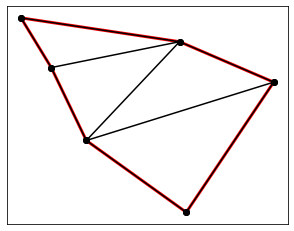

In [322]:
# Result using connection table 

random_contour=apply_procrustes(generate_contour(6))
original_quality_matrix,_=quality_matrix(random_contour)
ordered_matrix=order_quality_matrix(original_quality_matrix,random_contour,check_for_equal=False)
triangulate_old_vers(random_contour,ordered_matrix,recursive=True)


In [353]:
# Evaluating result using NN
nb_of_grid_points=20

directory='../polygon_datasets/validation_sets/grid_patch_regression/'
polygon_data=str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl'
point_coordinates=str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_point_coordinates.pkl'
estimated_points=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_points.pkl'
interpolatd_estimated_points=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_interpolated_points.pkl'
polygons=[]

if nb_of_points==1:
    
    with open(os.path.join(directory,polygon_data),'rb') as f:
        polygons=pickle.load(f)
else:
    with open(os.path.join(directory,polygon_data),'rb') as f:
        try:
            while True:
                polygons.append(pickle.load(f))
        except EOFError:
            pass

point_coordinates_list=[]
with open(os.path.join(directory,point_coordinates),'rb') as f:
    try:
        while True:
            point_coordinates_list.append(pickle.load(f))
    except EOFError:
        pass
    
with open(os.path.join(directory,estimated_points),'rb') as f:
    estimated_points=pickle.load(f)
    
with open(os.path.join(directory,interpolatd_estimated_points),'rb') as f:
       interpolatd_estimated_points=pickle.load(f)
        

[[[[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [ 0.99508155  0.25870986]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-0.00480932  0.45412145]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-0.13440754  0.86278798]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-1.03542791 -0.00446935]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-0.43294286 -0.45065737]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [ 0.61250609 -1.12049258]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-0.38091777  0.3462756 ]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [-0.3490263   0.07266232]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [ 0.32090279 -0.3235997 ]]

  [[ 0.99508155  0.25870986]
   [-0.00480932  0.45412145]
   [ 0.10896638  0.01804129]]]


 [[[-0.00480932  0.45412145]
   [-0.13440754  0.86278798]
   [ 0.99508155  0.25870986]]

  [[-0.00480932  0.

checked (3, 4)
checked (7, 0)
checked (6, 7)
checked (5, 6)
checked (4, 5)
0
triangle [2 3 5]
0.772374612634636
1
triangle [2 3 1]
0.7401905176187213
[(0.77237463, 5) (0.7401905 , 1)]
[(0.77237463, 5), (0.7401905, 1)]
checked (2, 3)
0
triangle [1 2 5]
0.7723746126346361
1
triangle [1 2 3]
0.7401905176187213
[(0.77237463, 5) (0.7401905 , 3)]
[(0.77237463, 5), (0.7401905, 3)]
checked (1, 2)
checked (0, 1)
[[0.         0.         0.         0.         0.         0.
  0.2531275  0.59681199]
 [0.         0.         0.         0.59681199 0.         0.59681199
  0.33172422 0.        ]
 [0.         0.59681199 0.         0.         0.1074673  0.59681199
  0.         0.        ]
 [0.         0.         0.1074673  0.         0.         0.59681199
  0.         0.        ]
 [0.         0.         0.1074673  0.59681199 0.         0.
  0.         0.        ]
 [0.         0.59681199 0.33172422 0.         0.         0.
  0.         0.51205993]
 [0.2531275  0.59681199 0.         0.         0.         0.

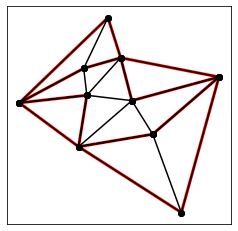

In [356]:
contour=polygons[5]
#point=point_coordinates_list[94]
point=point_coordinates_list[5]
point=sort_points(np.array(point).reshape(1,2*nb_of_points),nb_of_points)
point=np.array(point).reshape(nb_of_points,2)

contour_with_points=np.vstack([contour,point])
quality,_=Triangulation_with_points.quality_matrix(contour,point)
ordered_matrix=Triangulation_with_points.order_quality_matrix(quality,contour,contour_with_points,check_for_equal=True)

initial_elements,sub_elements=Triangulation_with_points.triangulate(contour,point,ordered_matrix,recursive=True,plot_mesh=True)

total_elements=concat_element_list(initial_elements,sub_elements)

mesh_minimum_quality=compute_minimum_quality_triangulated_contour(contour_with_points,total_elements)


print("Minimum quality:",mesh_minimum_quality )


checked (1, 2)
checked (2, 3)
checked (4, 5)
checked (3, 4)
checked (5, 0)
checked (0, 1)
initial set edges: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (3, 4)}
meshing polygon:  [[ 0.99508155  0.25870986]
 [-0.00480932  0.45412145]
 [-0.13440754  0.86278798]
 [-1.03542791 -0.00446935]
 [-0.43294286 -0.45065737]
 [ 0.61250609 -1.12049258]]  with inner points : [[-0.38091777  0.3462756 ]
 [-0.3490263   0.07266232]
 [ 0.32090279 -0.3235997 ]
 [ 0.10896638  0.01804129]]
Edge: (1, 2) targeting: 6
(1, 2, 6)
[[-0.00480932  0.45412145]
 [-0.13440754  0.86278798]
 [-0.38091777  0.3462756 ]]
set of forbidden inter section edges updated: set()
edges inserted: (1, 6)
set of interior edges updated: {(1, 6)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (2, 3), (1, 6), (5, 0), (3, 4)}
edges inserted: (2, 6)
set of interior edges updated: {(2, 6), (1, 6)}
set of edges updated: {(0, 1), (1, 2), (2, 6), (4, 5), (2, 3), (1, 6), (5, 0), (3, 4)}
element inserted: (1, 2, 6)
Spotted edges linked with point: 

[1, 2, 0]
[1, 2, 1]
[1, 2, 2]
[1, 2, 3]
[1, 2, 4]
[2, 0, 0]
[2, 0, 1]
[2, 0, 2]
[2, 0, 3]
[2, 0, 4]
[[0.1896699  0.         0.         0.         0.        ]
 [0.1896699  0.09868233 0.         0.         0.        ]
 [0.1896699  0.         0.         0.         0.        ]]
[(0.1896699, 1)]
checked (1, 2)
[(0.1896699, 1), (0.09868233, 1)]
checked (2, 0)
[(0.1896699, 1)]
checked (0, 1)
[[0.         0.         0.         0.         0.18966991]
 [0.         0.         0.         0.18966991 0.        ]
 [0.         0.         0.         0.09868233 0.18966991]] {(1, 2): [((0.1896699113014106, 3), (0.0, 4), (0.0, 2), (0.0, 1), (0.0, 0))], (2, 0): [((0.18966991130141056, 4), (0.09868232639419078, 3), (0.0, 2), (0.0, 1), (0.0, 0))], (0, 1): [((0.18966991130141056, 4), (0.0, 3), (0.0, 2), (0.0, 1), (0.0, 0))]}
[[ 0.61250609 -1.12049258]
 [ 0.99508155  0.25870986]
 [-0.3490263   0.07266232]]
initial set edges: {(0, 1), (2, 0), (1, 2)}
meshing polygon:  [[ 0.61250609 -1.12049258]
 [ 0.99508155  0

checked (2, 3)
checked (3, 0)
checked (1, 2)
checked (0, 1)
[[0.         0.         0.         0.51205993]
 [0.         0.         0.         0.51205993]
 [0.         0.51205993 0.         0.        ]
 [0.         0.51205993 0.         0.        ]] {(2, 3): [((0.5120599307737848, 1), (0.0, 3), (0.0, 2), (0.0, 0))], (3, 0): [((0.5120599307737846, 1), (0.0, 3), (0.0, 2), (0.0, 0))], (1, 2): [((0.5120599307737846, 3), (0.0, 2), (0.0, 1), (0.0, 0))], (0, 1): [((0.5120599307737846, 3), (0.0, 2), (0.0, 1), (0.0, 0))]}
initial set edges: {(0, 1), (3, 0), (2, 3), (1, 2)}
Edge: (2, 3) targeting: 1
(2, 3, 1)
Vertex locked: 2
edges inserted: (3, 1)
set of interior edges updated: {(3, 1)}
set of edges updated: {(0, 1), (1, 2), (3, 0), (3, 1), (2, 3)}
element inserted: (2, 3, 1)
Edge: (3, 0) targeting: 1
(3, 0, 1)
Vertex locked: 3
Vertex locked: 0
Vertex locked: 1
element inserted: (3, 0, 1)
Edge: (1, 2) targeting: 3
(1, 2, 3)
Element (2, 3, 1) already in set
Edge: (0, 1) targeting: 3
(0, 1, 3)
Ele

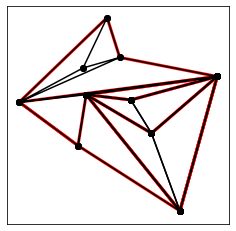

In [357]:
my_net.eval()
my_net=my_net.cpu()
random_contour_reshaped=contour_with_points.reshape(2*(nb_of_edges+nb_of_points))

predicted_quality_matrix=[]
for i in range(int(nb_of_edges)):
    random_contour_with_edge_label=np.hstack([random_contour_reshaped,np.array([i])])
    random_contour_with_edge_label=random_contour_with_edge_label.reshape(1,len(random_contour_with_edge_label))
    random_variable=Variable(torch.from_numpy(random_contour_with_edge_label).type(torch.FloatTensor))
    edge_quality=my_net(random_variable).data.numpy()
    predicted_quality_matrix.append(edge_quality)
    
predicted_quality_matrix=np.array(predicted_quality_matrix).reshape(nb_of_edges,nb_of_edges+nb_of_points)

predicted_ordered_matrix=order_quality_matrix(predicted_quality_matrix,contour)
initial_elements,sub_elements=Triangulation_with_points.triangulate(contour,point,predicted_ordered_matrix,recursive=True,plot_mesh=True)

total_elements=concat_element_list(initial_elements,sub_elements)


In [328]:
predicted_quality_matrix

array([[0.03696144, 0.0220573 , 0.0557451 , 0.03919806, 0.02444022,
        0.0580776 , 0.30621246, 0.2165569 , 0.11561495, 0.1461322 ],
       [0.03845082, 0.02555588, 0.05018008, 0.04015041, 0.02658573,
        0.05162774, 0.26370913, 0.21751833, 0.13909605, 0.14460115],
       [0.04254132, 0.02985019, 0.04396331, 0.04320887, 0.02885462,
        0.04424058, 0.21048313, 0.24234888, 0.18221878, 0.13296922],
       [0.04622987, 0.03520481, 0.03728956, 0.046074  , 0.03208628,
        0.03622207, 0.15574867, 0.25884166, 0.22619171, 0.13083151],
       [0.04397148, 0.0446196 , 0.03159457, 0.04522923, 0.04033174,
        0.02903466, 0.1351051 , 0.2001392 , 0.23657507, 0.19857702],
       [0.04046234, 0.05217236, 0.02822042, 0.04341208, 0.04744304,
        0.02463004, 0.13321878, 0.13595076, 0.23202547, 0.26696324]],
      dtype=float32)

In [274]:
random_contour_with_edge_label

array([[ 0.92793718,  0.30245348,  0.14672391,  0.99925893, -0.04473495,
         0.62180314, -0.65217113,  0.11886655, -0.51649281, -1.06434669,
         0.1387378 , -0.97803541,  0.21685002,  0.39102825, -0.10502397,
         0.13173418, -0.20441173, -0.37291855,  0.15934794, -0.10010848,
         0.        ]])

In [64]:
Polygons_reshaped_with_edges_label[:6]

array([[ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  0.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  1.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  2.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  3.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  4.        ],
       [ 1.03153405, -0.383725

In [80]:
quality_matrices.shape

(1765, 4, 6)

In [86]:
quality_matrices_reshaped

array([[[0.        , 0.        , 0.        , 0.        , 0.30624237,
         0.        ]],

       [[0.        , 0.        , 0.        , 0.2693817 , 0.30624237,
         0.10932361]],

       [[0.        , 0.2693817 , 0.        , 0.        , 0.2693817 ,
         0.30624237]],

       ...,

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.53670315]],

       [[0.18435143, 0.        , 0.        , 0.        , 0.15697959,
         0.53670315]],

       [[0.        , 0.        , 0.18435143, 0.        , 0.53670315,
         0.18435143]]])

In [96]:
len(quality_matrices_reshaped)


7060

In [123]:
Polygons_reshaped_with_edges_label[:7]

array([[ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  0.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  1.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  2.        ],
       [ 1.03153405, -0.38372593, -0.50582285,  0.97770921, -0.55412024,
         0.15050598,  0.02840905, -0.74448926,  0.13299216, -0.21108984,
         0.02614578,  0.13334986,  3.        ],
       [ 0.92125729, -0.26643743, -0.32783887,  0.97283146, -0.79636824,
         0.26435126,  0.20294982, -0.97074528,  0.03293677,  0.14602019,
         0.27105076, -0.339819  ,  0.        ],
       [ 0.92125729, -0.266437

In [137]:
Polygons_reshaped_with_edges_label.shape[1],quality_matrices_reshaped.shape[2]

(13, 6)

In [167]:
Polygons_reshaped_with_edges_label.shape[1],quality_matrices_reshaped.shape[2]

(13, 6)

In [206]:
contour_with_points

array([[ 1.07884784, -0.26079613],
       [-0.08445999,  0.84091032],
       [-1.16314955, -0.00757443],
       [ 0.1687617 , -0.57253976],
       [ 0.19944424,  0.00707185],
       [-0.2198509 ,  0.066967  ]])

In [302]:
Polygons_reshaped_with_edges_label.shape

(22158, 21)